In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import csv
from matplotlib import cm
import sys
# %matplotlib inline
pylab.rcParams['figure.figsize'] = 8, 5

import matplotlib
from astropy.io import ascii
# import mpld3
# from mpld3 import plugins, utils

from astropy import units as u
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord

import os, re
import urllib2

import seaborn as sns
sns.set(context='talk',style='ticks',font='serif',palette='muted',rc={"xtick.direction":"in","ytick.direction":"in"})
sns.reset_orig()

#mpld3.enable_notebook()
#mpld3.disable_notebook()

import ch_py as ch

from matplotlib.patches import Circle

### Specification for Each Survey

* Rosat http://arxiv.org/pdf/astro-ph/0109542.pdf
    * psf: total maximum 10 arcsecond
    * catalog name: http://www.xray.mpe.mpg.de/rosat/survey/rass-bsc/main/rass-bsc1-fmt.html
* NVSS: 
    * http://www.cv.nrao.edu/nvss/NVSShelp.html#general
    * https://heasarc.gsfc.nasa.gov/W3Browse/radio-catalog/nvss.html
* SUMSS: https://heasarc.gsfc.nasa.gov/W3Browse/radio-catalog/sumss.html
* WISE: 
    * http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-scan?utf8=%E2%9C%93&mission=irsa&projshort=WISE: (WISE All-Sky Source Catalog)

## ROSAT

In [2]:
headers=['ra','dec','dpos_arcs','xc','exc']
data_df = pd.read_csv('/Users/taweewat/Documents/xray_project/rosat/rosat_faint_new.txt', names=headers, index_col=False)

headers=['ra','dec','dpos_arcs','xc','exc']
data_df2 = pd.read_csv('/Users/taweewat/Documents/xray_project/rosat/rosat_new.txt', names=headers)

rosat=data_df.append(data_df2).reset_index(drop=True)
print data_df.shape, data_df2.shape, rosat.shape
rosat.head()

(105924, 5) (18806, 5) (124730, 5)


,ra,dec,dpos_arcs,xc,exc
0,169.16417,87.20055,13,0.01647,0.005433
1,168.12584,87.43764,13,0.01178,0.004613
2,215.27333,87.19417,29,0.00945,0.004970
3,216.42958,87.20597,13,0.01555,0.004870
4,148.65500,87.47236,19,0.02190,0.006527


In [113]:
rosat[(rosat['dec']>18.95)&(rosat['dec']<18.99)&(rosat['ra']>185)]

,ra,dec,dpos_arcs,xc,exc
45247,187.75250,18.97305,32,0.02405,0.010280
45248,186.44417,18.97750,17,0.04001,0.011450
45303,193.62416,18.95750,30,0.01689,0.007623
45304,191.55833,18.96375,23,0.01470,0.006396
45656,218.90167,18.98403,23,0.02036,0.008703
45657,222.62543,18.95986,14,0.03006,0.011000
45752,223.91333,18.97944,20,0.02610,0.010290
46174,254.39584,18.97778,17,0.01374,0.006013
46508,279.41000,18.96694,18,0.02093,0.008410
46638,293.28458,18.98083,17,0.02416,0.009346


In [ ]:
275.488811, 64.343437 #H1821 - [14.6375arcsec]
116.072720, 37.888097 #3C186 (z=1.068) - [1238.9arcsec] not detected
138.439538, 40.941174 #IRAS 09104+4109 (z=0.4422) - [9.65341arcsec]

In [149]:
c = SkyCoord(ra=[116.072720]*u.degree, dec=[37.888097]*u.degree)  
catalog = SkyCoord(ra=rosat['ra'].values*u.degree, dec=rosat['dec'].values*u.degree) 
idx, d2d, d3d = c.match_to_catalog_sky(catalog)  
print d2d.to(u.arcsecond)

[1238.9arcsec]


In [127]:
rosat.loc[idx[0]]

ra           138.44167
dec           40.93903
dpos_arcs     21.00000
xc             0.12130
exc            0.02355
Name: 113304, dtype: float64

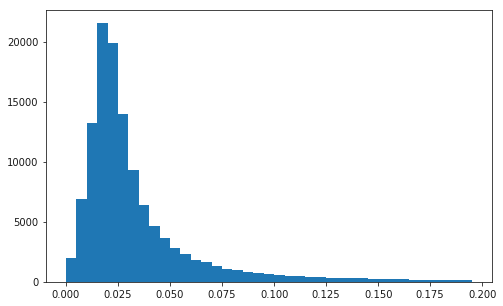

In [128]:
plt.hist(rosat.xc, bins=np.arange(0,0.2,0.005));

19.025310671


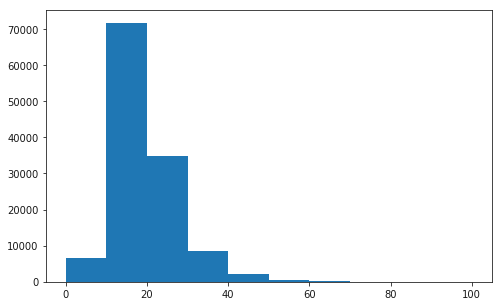

In [129]:
plt.hist(rosat.dpos_arcs,bins=[0,10,20,30,40,50,60,70,80,90,100]);
print np.mean(rosat.dpos_arcs)

## NVSS

In [117]:
dc=[]
with open('/Users/taweewat/Documents/xray_project/radio/nvss_cut.txt') as f:
    content = f.readlines()

def func(x):
    try:
        return float(x)
    except ValueError:
        return np.nan
    
for i in content:
    cont=i.rstrip('\n')
    h=func(cont[0:2])
    m=func(cont[3:5])
    s=func(cont[6:11])
    deg=func(cont[12:15])
    arcmin=func(cont[16:18])
    arcsec=func(cont[19:23])
    x=func(cont[24:29])
    flux=func(cont[29:36])
    co=[h,m,s,deg,arcmin,arcsec,x,flux]
    
    if not np.isnan(co[0]):
        con=co
    else:
        con=con+[co[7],co[2]*15,co[5]]
        dc.append(con)

headers=["ra_h", "ra_m", "ra_s", "dec_deg", "dec_arcm", "dec_arcs", "dist", "flux", "dflux", "dra_arcs",'ddec_arcs']
dc_df = pd.DataFrame(dc, columns=headers)

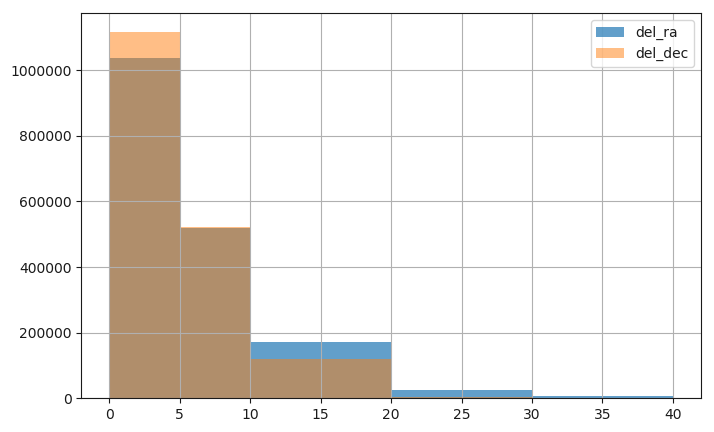

In [118]:
dc_df['dra_arcs'].hist(bins=[0,5,10,20,30,40],alpha=0.7,label='del_ra')
dc_df['ddec_arcs'].hist(bins=[0,5,10,20,30,40],alpha=0.5,label='del_dec')
plt.legend(loc='best')

In [119]:
dc_df['ra'] = dc_df['ra_h']*15.0+dc_df['ra_m']/4.0+dc_df['ra_s']/240.0
c1 = dc_df['dec_deg'].map(lambda x: x >= 0.0)
c2 = dc_df['dec_deg'].map(lambda x: x < 0.0)
dc_df.loc[c1,'dec'] = dc_df.loc[c1,'dec_deg']+dc_df.loc[c1,'dec_arcm']/60.0+dc_df.loc[c1,'dec_arcs']/3600.0
dc_df.loc[c2,'dec'] = dc_df.loc[c2,'dec_deg']-dc_df.loc[c2,'dec_arcm']/60.0-dc_df.loc[c2,'dec_arcs']/3600.0

dc_df.head()

,ra_h,ra_m,ra_s,dec_deg,dec_arcm,dec_arcs,dist,flux,dflux,dra_arcs,ddec_arcs,ra,dec
0,0.0,0.0,0.09,-34.0,7.0,9.5,99999.0,2.7,0.5,7.20,6.7,0.000375,-34.119306
1,0.0,0.0,0.13,-38.0,26.0,28.5,99999.0,3.1,0.6,9.75,11.5,0.000542,-38.441250
2,0.0,0.0,0.16,-4.0,2.0,42.3,14550.0,106.8,3.2,0.45,0.6,0.000667,-4.045083
3,0.0,0.0,0.18,32.0,12.0,33.3,99999.0,3.7,0.4,4.65,3.9,0.000750,32.209250
4,0.0,0.0,0.19,49.0,18.0,12.6,99999.0,2.4,0.5,13.80,9.0,0.000792,49.303500


In [121]:
# 138.439538, 40.941174
dc_df[(dc_df['ra']>186)&(dc_df['ra']<187)&(dc_df['dec']>18.96)&(dc_df['dec']<18.99)]

,ra_h,ra_m,ra_s,dec_deg,dec_arcm,dec_arcs,dist,flux,dflux,dra_arcs,ddec_arcs,ra,dec
914991,12.0,25.0,47.39,18.0,58.0,41.9,70565.0,67.2,2.1,0.45,0.6,186.447458,18.978306


## SUMSS

In [122]:
header_row=['ra_h','ra_m','ra_s','dec_deg', 'dec_arcm', 'dec_arcs','ra_err_arcs','dec_err_arcs','f0','ef0','f','ef']
su0 = pd.read_csv('/Users/taweewat/Documents/xray_project/radio/sumss_ff.txt', names=header_row)
su0['ra'] = su0.loc[:,'ra_h']*15.0+su0.loc[:,'ra_m']/4.0+su0.loc[:,'ra_s']/240.0
su0['dec'] = su0.loc[:,'dec_deg']-su0.loc[:,'dec_arcm']/60.0-su0.loc[:,'dec_arcs']/3600.0
su0.head()

,ra_h,ra_m,ra_s,dec_deg,dec_arcm,dec_arcs,ra_err_arcs,dec_err_arcs,f0,ef0,f,ef,ra,dec
0,0,0,0.00,-31,9,53.1,3.6,4.7,13.1,1.4,13.2,1.4,0.000000,-31.164750
1,0,0,0.03,-50,28,8.5,3.1,3.6,7.4,0.8,7.4,0.8,0.000125,-50.469028
2,0,0,0.10,-45,57,21.5,2.1,2.5,16.7,1.0,20.9,1.3,0.000417,-45.955972
3,0,0,0.26,-47,37,57.7,1.8,2.0,28.1,1.3,28.1,1.3,0.001083,-47.632694
4,0,0,1.72,-59,36,16.3,3.3,3.5,11.1,1.2,11.1,1.2,0.007167,-59.604528


In [123]:
rosat.shape, dc_df.shape, su0.shape

((124730, 5), (1763161, 13), (211050, 14))

In [124]:
cr=SkyCoord(ra=rosat['ra'].values*u.degree, dec=rosat['dec'].values*u.degree)  
cn=SkyCoord(ra=dc_df['ra'].values*u.degree, dec=dc_df['dec'].values*u.degree)  
cs=SkyCoord(ra=su0['ra'].values*u.degree, dec=su0['dec'].values*u.degree)  

DF=rosat
# DF['ALPHA_J2000_r']=df_r['ALPHA_J2000'].values
# DF['DELTA_J2000_r']=df_r['DELTA_J2000'].values
# DF['XWIN_IMAGE_r']=df_r['XWIN_IMAGE'].values
# DF['YWIN_IMAGE_r']=df_r['YWIN_IMAGE'].values
# DF['XWIN_WORLD_r']=df_r['XWIN_WORLD'].values
# DF['YWIN_WORLD_r']=df_r['YWIN_WORLD'].values

idxn, d2dn, d3dn=cr.match_to_catalog_sky(cn)
# DF['ALPHA_J2000_i']=df_ir['ALPHA_J2000'].values
# DF['DELTA_J2000_i']=df_ir['DELTA_J2000'].values
# DF['XWIN_IMAGE_i']=df_ir['XWIN_IMAGE'].values
# DF['YWIN_IMAGE_i']=df_ir['YWIN_IMAGE'].values
# DF['XWIN_WORLD_i']=df_ir['XWIN_WORLD'].values
# DF['YWIN_WORLD_i']=df_ir['YWIN_WORLD'].values

In [125]:
idxs, d2ds, d3ds=cr.match_to_catalog_sky(cs)
# df_gr=df_g.loc[idx]
# DF['ALPHA_J2000_g']=df_gr['ALPHA_J2000'].values
# DF['DELTA_J2000_g']=df_gr['DELTA_J2000'].values
# DF['XWIN_IMAGE_g']=df_gr['XWIN_IMAGE'].values
# DF['YWIN_IMAGE_g']=df_gr['YWIN_IMAGE'].values
# DF['XWIN_WORLD_g']=df_gr['XWIN_WORLD'].values
# DF['YWIN_WORLD_g']=df_gr['YWIN_WORLD'].values


# idx, d2d, d3d=cr.match_to_catalog_sky(cz)
# df_zr=df_z.loc[idx]
# DF['ALPHA_J2000_z']=df_zr['ALPHA_J2000'].values
# DF['DELTA_J2000_z']=df_zr['DELTA_J2000'].values
# DF['XWIN_IMAGE_z']=df_zr['XWIN_IMAGE'].values
# DF['YWIN_IMAGE_z']=df_zr['YWIN_IMAGE'].values
# DF['XWIN_WORLD_z']=df_zr['XWIN_WORLD'].values
# DF['YWIN_WORLD_z']=df_zr['YWIN_WORLD'].values

In [126]:
np.where(d2ds<30*u.arcsecond)[0], np.where(d2dn<30*u.arcsecond)[0]

(array([ 77365,  77471,  77472, ..., 124694, 124709, 124717]),
 array([     0,     15,     34, ..., 124719, 124722, 124727]))

In [127]:
np.intersect1d(np.where(d2ds<20*u.arcsecond)[0],np.where(d2dn<20*u.arcsecond)[0]).shape #number of overlap between NVSS and SUMSS

(285,)

In [128]:
idxn.shape

(124730,)

In [151]:
df_r_nv=dc_df.loc[idxn].copy()
df_r_nv.loc[:,'d2d_nv']=d2dn.to(u.arcsecond).value.tolist()

df_r_nv=df_r_nv.rename(columns={'ra':'ra_nv','dec':'dec_nv'})
df_r_nv=df_r_nv.set_index([np.arange(0,rosat.shape[0],1).tolist()])
rosat_nv=pd.concat([rosat,df_r_nv], axis=1)

rosat_nv.head()

,ra,dec,dpos_arcs,xc,exc,ra_h,ra_m,ra_s,dec_deg,dec_arcm,dec_arcs,dist,flux,dflux,dra_arcs,ddec_arcs,ra_nv,dec_nv,d2d_nv
0,169.16417,87.20055,13,0.01647,0.005433,11.0,16.0,50.98,87.0,11.0,45.8,99999.0,5.1,0.4,51.60,2.2,169.212417,87.196056,18.272064
1,168.12584,87.43764,13,0.01178,0.004613,11.0,5.0,15.30,87.0,29.0,51.8,99999.0,35.2,1.1,12.00,0.6,166.313750,87.497722,360.334457
2,215.27333,87.19417,29,0.00945,0.004970,14.0,22.0,37.86,87.0,6.0,24.4,99999.0,4.3,0.5,63.75,4.0,215.657750,87.106778,322.044755
3,216.42958,87.20597,13,0.01555,0.004870,14.0,22.0,37.86,87.0,6.0,24.4,99999.0,4.3,0.5,63.75,4.0,215.657750,87.106778,382.766625
4,148.65500,87.47236,19,0.02190,0.006527,9.0,55.0,3.17,87.0,31.0,26.7,99999.0,5.6,0.5,63.60,2.7,148.763208,87.524083,186.978702


In [152]:
df_r_nv.shape, rosat.shape, rosat_nv.shape

((124730, 14), (124730, 5), (124730, 19))

In [166]:
rosat_nv['ra_shift']=np.abs((rosat_nv['ra']-rosat_nv['ra_nv'])*3600)
rosat_nv['dec_shift']=np.abs((rosat_nv['dec']-rosat_nv['dec_nv'])*3600)

rosat_nv['ra_err']=2*(rosat_nv['dpos_arcs']+rosat_nv['dra_arcs']).values
rosat_nv['dec_err']=2*(rosat_nv['dpos_arcs']+rosat_nv['ddec_arcs']).values


rosat_nv[(rosat_nv['ra']>186)&(rosat_nv['ra']<187)&(rosat_nv['dec']>18.9)&(rosat_nv['dec']<19)][['ra','dec','d2d_nv','ra_shift','ra_err','dpos_arcs','dra_arcs']]

,ra,dec,d2d_nv,ra_shift,ra_err,dpos_arcs,dra_arcs
45248,186.44417,18.9775,11.564065,11.838,34.9,17,0.45


In [154]:
rosat_nv.loc[[113304]]

,ra,dec,dpos_arcs,xc,exc,ra_h,ra_m,ra_s,dec_deg,dec_arcm,...,dflux,dra_arcs,ddec_arcs,ra_nv,dec_nv,d2d_nv,ra_shift,dec_shift,ra_err,dec_err
113304,138.44167,40.93903,21,0.1213,0.02355,9.0,13.0,45.43,40.0,56.0,...,0.9,1.35,1.2,138.439292,40.941861,12.070935,8.562,10.192,44.7,44.4


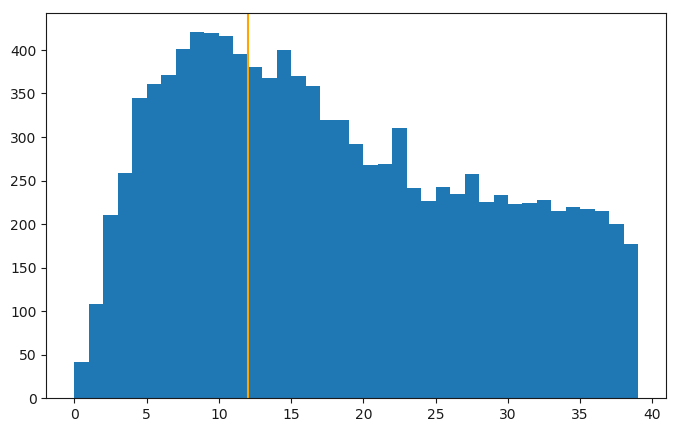

In [164]:
plt.hist(rosat_nv['d2d_nv'].values,bins=np.arange(0,40,1));
plt.axvline(12,c='orange')

In [156]:
# objects that are closed, but not close enough based on uncertainty

aa=rosat_nv[rosat_nv['d2d_nv']<11].index.values
bb=rosat_nv[(np.abs((rosat_nv['ra']-rosat_nv['ra_nv'])*3600) < 2*(rosat_nv['dpos_arcs']+rosat_nv['dra_arcs']).values) &\
(np.abs((rosat_nv['dec']-rosat_nv['dec_nv'])*3600) < 2*(rosat_nv['dpos_arcs']+rosat_nv['ddec_arcs']).values)].index.values

cc=rosat_su[rosat_su['d2d_su']<11].index.values
dd=rosat_su[(np.abs((rosat_su['ra']-rosat_su['ra_su'])*3600) < 2*(rosat_su['dpos_arcs']+rosat_su['ra_err_arcs']).values) &\
(np.abs((rosat_su['dec']-rosat_su['dec_su'])*3600) < 2*(rosat_su['dpos_arcs']+rosat_su['dec_err_arcs']).values)].index.values
rosat_su.loc[np.setdiff1d(cc,dd)]

print aa.shape, bb.shape, cc.shape, dd.shape

rosat_nv2=rosat_nv.loc[np.setdiff1d(aa,bb)]
rosat_su2=rosat_su.loc[np.setdiff1d(cc,dd)]
print rosat_nv2.shape, rosat_su2.shape

rosat_nv2=rosat_nv2[['ra','dec','dpos_arcs','xc','exc','flux','dflux','ra_nv','dec_nv','d2d_nv','dra_arcs','ddec_arcs']]
rosat_nv2['flag']='nv'
rosat_su2=rosat_su2[['ra','dec','dpos_arcs','xc','exc','f','ef','ra_su','dec_su','d2d_su','ra_err_arcs','dec_err_arcs']]
rosat_su2['flag']='su'

rosat_nv2=rosat_nv2.rename(columns={'ra_nv':'ra_radio','dec_nv':'dec_radio','d2d_nv':'d2d_radio'})
rosat_su2=rosat_su2.rename(columns={'f':'flux','ef':'dflux','ra_su':'ra_radio','dec_su':'dec_radio','d2d_su':'d2d_radio','ra_err_arcs':'dra_arcs','dec_err_arcs':'ddec_arcs'})

rosat_rad2=pd.concat([rosat_nv2,rosat_su2])
print rosat_rad2.shape  #no duplicate index (checked)

rosat_rad2=rosat_rad2.set_index([np.arange(1,rosat_rad2.shape[0]+1,1).tolist()])

text_file = open("/Users/taweewat/Documents/xray_project/result/query-new-addition.txt", "w")
text_file.write("|         ra|       dec|\n")
text_file.write("|     double|    double|\n")
text_file.write("|           |          |\n")
text_file.write("|       null|      null|\n")
for i, item in enumerate(rosat_rad2['ra'].values):
    text_file.write("%12f%+11.5f\n" % (rosat_rad2['ra'].values[i], rosat_rad2['dec'].values[i]))
text_file.close()

KeyError: 'd2d_su'

In [169]:
# rosat_nv=rosat_nv[(np.abs((rosat_nv['ra']-rosat_nv['ra_nv'])*3600) < rosat_nv['dpos_arcs']+rosat_nv['dra_arcs']).values &\
# (np.abs((rosat_nv['dec']-rosat_nv['dec_nv'])*3600) < rosat_nv['dpos_arcs']+rosat_nv['ddec_arcs']).values]

rosat_nv=rosat_nv[(np.abs((rosat_nv['ra']-rosat_nv['ra_nv'])*3600) < 2*(rosat_nv['dpos_arcs']+rosat_nv['dra_arcs']).values) &\
(np.abs((rosat_nv['dec']-rosat_nv['dec_nv'])*3600) < 2*(rosat_nv['dpos_arcs']+rosat_nv['ddec_arcs']).values)]

In [171]:
rosat_nv[(rosat_nv['ra']>186)&(rosat_nv['ra']<187)&(rosat_nv['dec']>18.9)&(rosat_nv['dec']<18.99)][['ra','dec','d2d_nv','ra_shift','ra_err','dpos_arcs','dra_arcs']]

,ra,dec,d2d_nv,ra_shift,ra_err,dpos_arcs,dra_arcs
45248,186.44417,18.9775,11.564065,11.838,34.9,17,0.45


In [172]:
df_r_su=su0.loc[idxs].copy()
df_r_su.loc[:,'d2d_su']=d2ds.to(u.arcsecond).value.tolist()

df_r_su=df_r_su.rename(columns={'ra':'ra_su','dec':'dec_su'})
df_r_su=df_r_su.set_index([np.arange(0,rosat.shape[0],1).tolist()])
rosat_su=pd.concat([rosat,df_r_su], axis=1)

rosat_su.head()

,ra,dec,dpos_arcs,xc,exc,ra_h,ra_m,ra_s,dec_deg,dec_arcm,dec_arcs,ra_err_arcs,dec_err_arcs,f0,ef0,f,ef,ra_su,dec_su,d2d_su
0,169.16417,87.20055,13,0.01647,0.005433,8,47,46.44,-26,46,41.7,2.3,4.0,26.5,2.6,26.5,2.6,131.943500,-26.778250,412332.998087
1,168.12584,87.43764,13,0.01178,0.004613,8,47,46.44,-26,46,41.7,2.3,4.0,26.5,2.6,26.5,2.6,131.943500,-26.778250,412921.426893
2,215.27333,87.19417,29,0.00945,0.004970,16,55,40.25,-25,59,54.7,2.1,3.4,62.1,3.5,99.1,9.1,253.917708,-25.998528,409660.467132
3,216.42958,87.20597,13,0.01555,0.004870,16,55,40.25,-25,59,54.7,2.1,3.4,62.1,3.5,99.1,9.1,253.917708,-25.998528,409571.133250
4,148.65500,87.47236,19,0.02190,0.006527,8,47,46.44,-26,46,41.7,2.3,4.0,26.5,2.6,26.5,2.6,131.943500,-26.778250,411678.539105


In [173]:
# rosat_su=rosat_su[(np.abs((rosat_su['ra']-rosat_su['ra_su'])*3600) < rosat_su['dpos_arcs']+rosat_su['ra_err_arcs']).values &\
# (np.abs((rosat_su['dec']-rosat_su['dec_su'])*3600) < rosat_su['dpos_arcs']+rosat_su['dec_err_arcs']).values]

rosat_su=rosat_su[(np.abs((rosat_su['ra']-rosat_su['ra_su'])*3600) < 2*(rosat_su['dpos_arcs']+rosat_su['ra_err_arcs']).values) &\
(np.abs((rosat_su['dec']-rosat_su['dec_su'])*3600) < 2*(rosat_su['dpos_arcs']+rosat_su['dec_err_arcs']).values)]

(array([ 489.,  550.,  309.,  156.,   87.]),
 array([ 0, 10, 20, 30, 40, 50]),
 <a list of 5 Patch objects>)

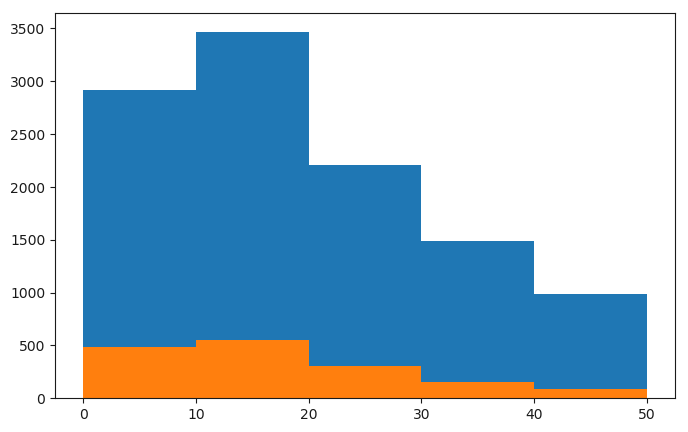

In [174]:
plt.hist(rosat_nv['d2d_nv'],bins=[0,10,20,30,40,50])
plt.hist(rosat_su['d2d_su'],bins=[0,10,20,30,40,50])

In [175]:
rosat_su[rosat_su['d2d_su']>30].head()

,ra,dec,dpos_arcs,xc,exc,ra_h,ra_m,ra_s,dec_deg,dec_arcm,dec_arcs,ra_err_arcs,dec_err_arcs,f0,ef0,f,ef,ra_su,dec_su,d2d_su
77489,20.73167,-30.78222,14,0.04401,0.013920,1,22,53.54,-30,46,18.1,5.5,7.2,14.7,2.1,21.1,3.1,20.723083,-30.771694,46.272662
77687,35.35083,-30.60194,19,0.01659,0.007482,2,21,27.11,-30,35,35.7,4.7,6.5,11.9,1.7,14.5,2.1,35.362958,-30.593250,48.899328
78061,72.29333,-30.66917,32,0.04031,0.016070,4,49,8.22,-30,39,30.1,3.6,6.7,13.3,2.0,16.2,2.5,72.284250,-30.658361,48.007623
78652,102.05208,-30.73222,18,0.01449,0.006247,6,48,13.99,-30,44,22.8,1.5,1.7,926.0,27.9,985.3,29.7,102.058292,-30.739667,32.986512
78705,105.66792,-28.70667,33,0.03390,0.011240,7,2,40.30,-28,41,48.4,1.5,1.8,177.8,5.7,177.8,5.7,105.667917,-28.696778,35.612002


In [176]:
rosat_nv=rosat_nv[['ra','dec','dpos_arcs','xc','exc','flux','dflux','ra_nv','dec_nv','d2d_nv','dra_arcs','ddec_arcs']]
rosat_nv['flag']='nv'
rosat_su=rosat_su[['ra','dec','dpos_arcs','xc','exc','f','ef','ra_su','dec_su','d2d_su','ra_err_arcs','dec_err_arcs']]
rosat_su['flag']='su'

In [177]:
rosat_nv.shape, rosat_su.shape

((12623, 13), (1705, 13))

In [178]:
rosat_nv=rosat_nv.rename(columns={'ra_nv':'ra_radio','dec_nv':'dec_radio','d2d_nv':'d2d_radio'})
rosat_su=rosat_su.rename(columns={'f':'flux','ef':'dflux','ra_su':'ra_radio','dec_su':'dec_radio','d2d_su':'d2d_radio','ra_err_arcs':'dra_arcs','dec_err_arcs':'ddec_arcs'})

In [179]:
rosat_rad=pd.concat([rosat_nv,rosat_su])
rosat_rad.shape

(14328, 13)

In [180]:
np.sum(rosat_rad['flag']=='nv')

12623

In [181]:
rosat_rad.head()

,ra,dec,dpos_arcs,xc,exc,flux,dflux,ra_radio,dec_radio,d2d_radio,dra_arcs,ddec_arcs,flag
112,33.25959,84.33694,17,0.01036,0.004806,57.1,1.8,33.254125,84.333444,12.732965,5.10,0.6,nv
161,51.57542,86.93625,10,0.02236,0.007322,8.4,0.5,51.565875,86.939889,13.227959,24.75,1.4,nv
180,65.18333,84.82361,11,0.01612,0.006578,36.3,1.2,65.187000,84.823194,1.912859,6.30,0.7,nv
187,51.20042,84.55736,14,0.02330,0.008210,9.2,1.3,51.190083,84.562944,20.411165,26.55,5.6,nv
189,57.61292,84.42986,22,0.02209,0.007813,3.4,0.5,57.631417,84.429694,6.490829,62.70,4.5,nv


In [182]:
rosat_rad=rosat_rad[~rosat_rad.index.duplicated(keep='first')]

In [183]:
rosat_rad=rosat_rad.set_index([np.arange(1,rosat_rad.shape[0]+1,1).tolist()])

In [184]:
rosat_rad.shape

(13800, 13)

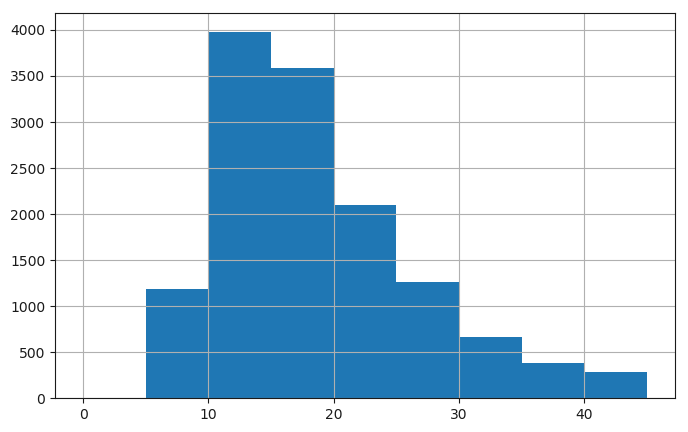

In [185]:
rosat_rad['dpos_arcs'].hist(bins=np.arange(0,50,5))

In [189]:
rosat_rad[(rosat_rad['ra']>186)&(rosat_rad['ra']<187)&(rosat_rad['dec']>18.9)&(rosat_rad['dec']<18.99)][['ra','dec']]#,'d2d_nv']]#,'ra_shift','ra_err','dpos_arcs','dra_arcs']]

,ra,dec
4537,186.44417,18.9775


In [186]:
np.sum([rosat_rad['flag']=='nv']), np.sum([rosat_rad['flag']=='su'])

(12623, 1177)

In [870]:
text_file = open("/Users/taweewat/Documents/xray_project/result/query-new-v2.txt", "w")
text_file.write("|         ra|       dec|\n")
text_file.write("|     double|    double|\n")
text_file.write("|           |          |\n")
text_file.write("|       null|      null|\n")
for i, item in enumerate(rosat_rad['ra'].values):
    text_file.write("%12f%+11.5f\n" % (rosat_rad['ra'].values[i], rosat_rad['dec'].values[i]))
text_file.close()

<hr>

## WISE

In [157]:
headers=['cntr_01','dist_x','pang_x','ra_01','dec_01','designation','ra_w','dec_w','sigra','sigdec','sigradec','w1mpro','w1sigmpro','w1snr','w1rchi2','w2mpro','w2sigmpro','w2snr','w2rchi2','w3mpro','w3sigmpro','w3snr','w3rchi2','w4mpro','w4sigmpro','w4snr','w4rchi2','n_2mass','j_m_2mass','j_msig_2mass','h_m_2mass','h_msig_2mass','k_m_2mass','k_msig_2mass']
wi0 = pd.read_csv('/Users/taweewat/Documents/xray_project/wise_2mass/wise_2mass_total_v2.tbl', sep=r"\s+", skiprows=83, names=headers, low_memory=False)

headers=['cntr_01','dist_x','pang_x','ra_01','dec_01','designation','ra_w','dec_w','sigra','sigdec','sigradec','w1mpro','w1sigmpro','w1snr','w1rchi2','w2mpro','w2sigmpro','w2snr','w2rchi2','w3mpro','w3sigmpro','w3snr','w3rchi2','w4mpro','w4sigmpro','w4snr','w4rchi2','j_m_2mass','j_msig_2mass','h_m_2mass','h_msig_2mass','k_m_2mass','k_msig_2mass']
wi1 = pd.read_csv('/Users/taweewat/Documents/xray_project/wise_2mass/wise_2mass_addition.tbl', sep=r"\s+", skiprows=83, names=headers, low_memory=False) #59 additonal objects

wi1['cntr_01']=wi1['cntr_01']+13800

wi0=wi0.append(wi1,sort=False)

for i in headers:
    wi0[i]=wi0[i].apply(func)

In [661]:
rosat_rad2=rosat_rad2.set_index(rosat_rad2.index+13800)
rosat_rad=rosat_rad.append(rosat_rad2,sort=False)

In [662]:
rosat_rad.index=rosat_rad.index = np.arange(1, len(rosat_rad) + 1)

In [228]:
# 275.488811,64.343437
DF=wi0[(wi0['ra_01']>186)&(wi0['ra_01']<187)&(wi0['dec_01']>18.9)&(wi0['dec_01']<18.99)].sort_values(by='k_m_2mass').iloc[0:1]
# rosat_rad[(rosat_rad['ra']>275)&(rosat_rad['ra']<276)&(rosat_rad['dec']>64)&(rosat_rad['dec']<65)]

In [664]:
wi0.shape, wi0['k_m_2mass'].dropna().shape

((62553, 34), (21027,))

In [217]:
# wi0[wi0['cntr_01']==1][~wi0[wi0['cntr_01']==1]
wi0[wi0['cntr_01']==4537][~wi0[wi0['cntr_01']==4537]['w4mpro'].isnull()].sort_values('w1mpro')

,cntr_01,dist_x,pang_x,ra_01,dec_01,designation,ra_w,dec_w,sigra,sigdec,...,w4sigmpro,w4snr,w4rchi2,n_2mass,j_m_2mass,j_msig_2mass,h_m_2mass,h_msig_2mass,k_m_2mass,k_msig_2mass
20866,4537.0,11.356370,73.342944,186.44417,18.9775,NaN,186.447366,18.978404,0.0659,0.0667,...,0.463,2.3,0.8631,0.0,NaN,NaN,NaN,NaN,NaN,NaN
20865,4537.0,8.013658,5.624224,186.44417,18.9775,NaN,186.444401,18.979715,0.0916,0.0942,...,NaN,0.1,0.8631,1.0,17.071,0.202,15.865,NaN,15.294,0.153
20867,4537.0,17.068657,-67.631482,186.44417,18.9775,NaN,186.439533,18.979304,0.1064,0.1167,...,NaN,1.2,0.7998,0.0,NaN,NaN,NaN,NaN,NaN,NaN
20868,4537.0,19.181237,12.361105,186.44417,18.9775,NaN,186.445376,18.982705,0.1237,0.1326,...,0.487,2.2,0.7349,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
DF=pd.DataFrame(columns=headers)

for i in np.arange(1,len(wi0),1):
    df_i=wi0[wi0['cntr_01']==i][~wi0[wi0['cntr_01']==i]['w4sigmpro'].isnull()]  #picking row with know w4 detection
    if df_i.shape[0] > 0:
#         df_ii=df_i.iloc[0]
        df_ii=df_i.sort_values('w4mpro').iloc[0]
        DF=DF.append(df_ii)

In [232]:
DF['cntr_01']=DF['cntr_01'].apply(int)
DF=DF.set_index(DF['cntr_01'])

In [194]:
print len(wi0['j_m_2mass']), len(wi0['j_m_2mass'].dropna())
print len(wi0['w4sigmpro']), len(wi0['w4sigmpro'].dropna())
print len(wi0['w1sigmpro']), len(wi0['w1sigmpro'].dropna())

62553 21028
62553 12238
62553 62204


In [195]:
DF.shape, rosat_rad.shape

((7428, 34), (13800, 13))

In [233]:
DF[(DF['ra_01']>186)&(DF['ra_01']<187)&(DF['dec_01']>18.9)&(DF['dec_01']<18.99)]

,cntr_01,dist_x,pang_x,ra_01,dec_01,designation,ra_w,dec_w,sigra,sigdec,...,w4sigmpro,w4snr,w4rchi2,n_2mass,j_m_2mass,j_msig_2mass,h_m_2mass,h_msig_2mass,k_m_2mass,k_msig_2mass
cntr_01,,,,,,,,,,,,,,,,,,,,,
4537,4537,8.013658,5.624224,186.44417,18.9775,NaN,186.444401,18.979715,0.0916,0.0942,...,NaN,0.1,0.8631,1.0,17.071,0.202,15.865,NaN,15.294,0.153


In [234]:
rosat_rad_wise=pd.concat([DF,rosat_rad], axis=1,join='inner') #4/18/19: change rosat_rad to rosat_rad2 for additional target
rosat_rad_wise.shape 

(1, 47)

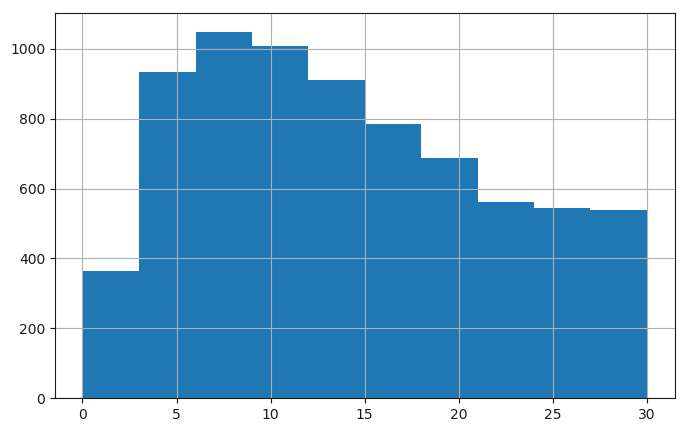

In [198]:
# rosat_rad_wise_cut['dist_x'].hist()
rosat_rad_wise['dist_x'].hist()

In [235]:
rosat_rad_wise=rosat_rad_wise.drop('designation', axis=1)

In [236]:
rosat_rad_wise[(rosat_rad_wise['ra']>186)&(rosat_rad_wise['ra']<187)&(rosat_rad_wise['dec']>18)&(rosat_rad_wise['dec']<19)]

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,xc,exc,flux,dflux,ra_radio,dec_radio,d2d_radio,dra_arcs,ddec_arcs,flag
4537,4537,8.013658,5.624224,186.44417,18.9775,186.444401,18.979715,0.0916,0.0942,-0.0121,...,0.04001,0.01145,67.2,2.1,186.447458,18.978306,11.564065,0.45,0.6,nv


In [235]:
rosat_rad_wise_cut=rosat_rad_wise[rosat_rad_wise['dist_x']<=2.*rosat_rad_wise['dpos_arcs']]

In [245]:
c_01=SkyCoord(ra=rosat_rad_wise['ra_01'].values*u.degree, dec=rosat_rad_wise['dec_01'].values*u.degree)  
c_w=SkyCoord(ra=rosat_rad_wise['ra_w'].values*u.degree, dec=rosat_rad_wise['dec_w'].values*u.degree)  

<hr> 

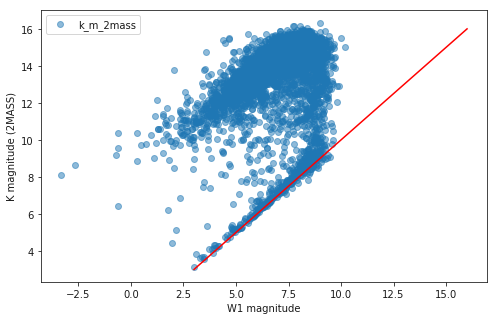

In [671]:
aa=rosat_rad_wise.dropna()
plt.scatter(aa['w4mpro'],aa['k_m_2mass'],alpha=0.5)
plt.xlabel('W1 magnitude')
plt.ylabel('K magnitude (2MASS)')
plt.plot([3,16],[3,16],color='red')
plt.legend(loc='best')
# plt.axis([8,17,10,17])

In [237]:
final=rosat_rad_wise#_cut
final.shape

(1, 46)

In [238]:
#flag 1 (NVSS 1.4 GHz) and 2 (SUMSS 843 MHz) for different catalogs

#fixed the ratio
ratio=(1.4/0.843)**(-1.)
print ratio
final.loc[:,'flux_adj']=final.loc[:,'flux']
final.loc[final['flag']=='su','flux_adj']=final.loc[final['flag']=='su','flux']*ratio
final.loc[:,'dflux_adj']=final.loc[:,'dflux']
final.loc[final['flag']=='su','dflux_adj']=final.loc[final['flag']=='su','dflux']*ratio

#Convert w1, ew1 to flux 
#convert Mab = Mvega+2.699 Jy, erg s-1 cm-2 Hz-1
final.loc[:,'wi_f']=3631.*1.0e-23*10.**(-(final.loc[:,'w4mpro']+6.620)/2.5) # F0=3631 Jy, 
final.loc[:,'ewi_f']=3631.*1.0e-23*(10.**(-(final.loc[:,'w4mpro']-final.loc[:,'w4sigmpro']+6.620)/2.5)-\
                                    10.**(-(final.loc[:,'w4mpro']+final.loc[:,'w4sigmpro']+6.620)/2.5))/2.0  

# final.loc[:,'wi0_f']=3631.*1.0e-23*10.**(-(final.loc[:,'w1mpro']+2.699)/2.5) # F0=3631 Jy, 
# final.loc[:,'ewi0_f']=3631.*1.0e-23*(10.**(-(final.loc[:,'w1mpro']-final.loc[:,'w1sigmpro']+2.699)/2.5)-\
#                                     10.**(-(final.loc[:,'w1mpro']+final.loc[:,'w1sigmpro']+2.699)/2.5))/2.0  

final.loc[:,'wi0_f']=666.7*1.0e-23*10.**(-(final.loc[:,'k_m_2mass'])/2.5)
final.loc[:,'ewi0_f']=666.7*1.0e-23*(10.**(-(final.loc[:,'k_m_2mass']+final.loc[:,'k_msig_2mass'])/2.5)-\
                                    10.**(-(final.loc[:,'k_m_2mass']-final.loc[:,'k_msig_2mass'])/2.5))/2.0

#convert ROSAT to flux
final.loc[:,'x_f']=final.loc[:,'xc']*1.0e-11/5.56e17 #(2.3 keV/h = 5.56e17 Hz)
final.loc[:,'ex_f']=final.loc[:,'exc']*1.0e-11/5.56e17

#convert Radio data
final.loc[:,'rad_f']=final.loc[:,'flux_adj']*1.0e-3*1.0e-23  #(convert mJy to erg/s/cm^2/Hz)
final.loc[:,'erad_f']=final.loc[:,'dflux_adj']*1.0e-3*1.0e-23

0.602142857143


In [239]:
#define new columns
final.loc[:,'xray']=np.log10(final['x_f'].values)-np.log10(final['wi0_f'].values)
final.loc[:,'mir']=np.log10(final['wi_f'].values)-np.log10(final['wi0_f'].values)
final.loc[:,'radio']=np.log10(final['rad_f'].values)-np.log10(final['wi0_f'].values)

final.loc[:,'exray']=((0.434*final['ex_f']/final['x_f'])**2+(0.434*final['ewi0_f']/final['wi0_f'])**2)**0.5
final.loc[:,'emir']=((0.434*final['ewi_f']/final['wi_f'])**2+(0.434*final['ewi0_f']/final['wi0_f'])**2)**0.5
final.loc[:,'eradio']=((0.434*final['erad_f']/final['rad_f'])**2+(0.434*final['ewi0_f']/final['wi0_f'])**2)**0.5

In [240]:
final.shape

(1, 62)

In [241]:
final[(final['ra']>186)&(final['ra']<187)&(final['dec']>18)&(final['dec']<19)]

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,x_f,ex_f,rad_f,erad_f,xray,mir,radio,exray,emir,eradio
4537,4537,8.013658,5.624224,186.44417,18.9775,186.444401,18.979715,0.0916,0.0942,-0.0121,...,7.196043e-31,2.059353e-31,6.720000e-25,2.100000e-26,-3.849237,0.654896,2.121039,0.138532,NaN,0.062842


In [242]:
# final=final[final['w1mpro']>9.]
final=final[final['k_m_2mass']>9.]

final.shape
# final=final[final['wi0_f']>9.]

(1, 62)

In [243]:
final[(final['ra']>186)&(final['ra']<187)&(final['dec']>18)&(final['dec']<19)]

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,x_f,ex_f,rad_f,erad_f,xray,mir,radio,exray,emir,eradio
4537,4537,8.013658,5.624224,186.44417,18.9775,186.444401,18.979715,0.0916,0.0942,-0.0121,...,7.196043e-31,2.059353e-31,6.720000e-25,2.100000e-26,-3.849237,0.654896,2.121039,0.138532,NaN,0.062842


In [245]:
final.to_csv('sdss123.csv',index=False)

In [679]:
# final.to_csv('/Users/taweewat/Documents/xray_project/ned-result/final_all_new.csv', index=False)
final.to_csv('/Users/taweewat/Documents/xray_project/ned-result/final_all_new_2massK.csv', index=False)

In [162]:
final0=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/final_all_new.csv',index_col=0)
final=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/final_all_new_2massK.csv',index_col=0)
print final0.shape, final.shape

final0=final0.rename(columns={'xray':'xray0'})

(4206, 61) (4500, 61)


In [163]:
final0[(final0['dec_01']>18.96)&(final0['dec_01']<19)&(final0['ra_01']>180)]

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,x_f,ex_f,rad_f,erad_f,xray0,mir,radio,exray,emir,eradio
cntr_01,,,,,,,,,,,,,,,,,,,,,


In [27]:
# 	-31.42375

# final[final['ra_01']==215.88333]
final.shape

(4500, 61)

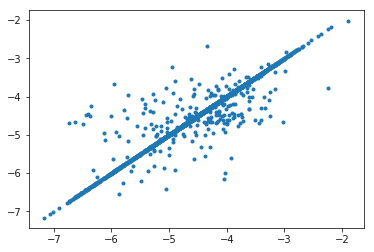

In [9]:
az=final0[['xray0']].join(final[['xray']])
plt.scatter(az['xray0'],az['xray'],marker='.')

In [682]:
cut_diff=final.loc[final.index.difference(final0.index)]

In [683]:
cut_diff.shape

(397, 61)

In [684]:
# final=dfq.copy()

In [29]:
# final = rosat_rad_wise#_cut
obj={'Abell 1835':(210.258631,2.878468),'Phoenix':(356.18307,-42.720204),'NGC 1275':(49.950416,41.51166),\
     'PKS1353-341':(209.02244416666667,-34.35301638888889),'IRAS09104+4109':(138.439538, 40.941174),'H1821':(275.488811,64.343437)}
# obj={'H1821':(275.488811,64.343437),'3C186':(116.072720,37.888097)}
# obj={,'Phoenix':(356.18307,-42.720204)}
all_match={}
for i, item in enumerate(obj.keys()):
    print item
    matched=final.loc[(((final.loc[:,'ra']-obj[item][0])**2+(final.loc[:,'dec']-obj[item][1])**2)**0.5).idxmin(),:]
    print (matched['ra']-obj[item][0])*3600
    print (matched['dec']-obj[item][1])*3600
    all_match[item]=matched
    
all_match_df=pd.DataFrame.from_dict(all_match,orient='index')
all_match_df.reset_index(level=0, inplace=True)

H1821
1.29240000001
14.6268
Phoenix
2.44799999996
-6.75359999998
NGC 1275
-10.4976
10.044
PKS1353-341
-5.81099999996
26.339
IRAS09104+4109
7.67519999996
-7.7184
Abell 1835
0.464399999953
7.0272


In [686]:
# all_match['NGC 1275']
# all_match['H1821']

In [687]:
all_match['Phoenix']['mir']

all_match['Phoenix']['xray']-np.log10(3), all_match['Phoenix']['mir']-np.log10(3*5), all_match['Phoenix']['radio']-np.log10(3.*3)

(-3.8142440461296623, 0.85280453473431894, 0.80785175597067493)

In [690]:
# final[(final['xray']+final['exray']>-3.8142440461295912)&(final['mir']+final['emir']>0.85280453473164686)&\
# (final['radio']+final['eradio']>0.8078517559711077)]

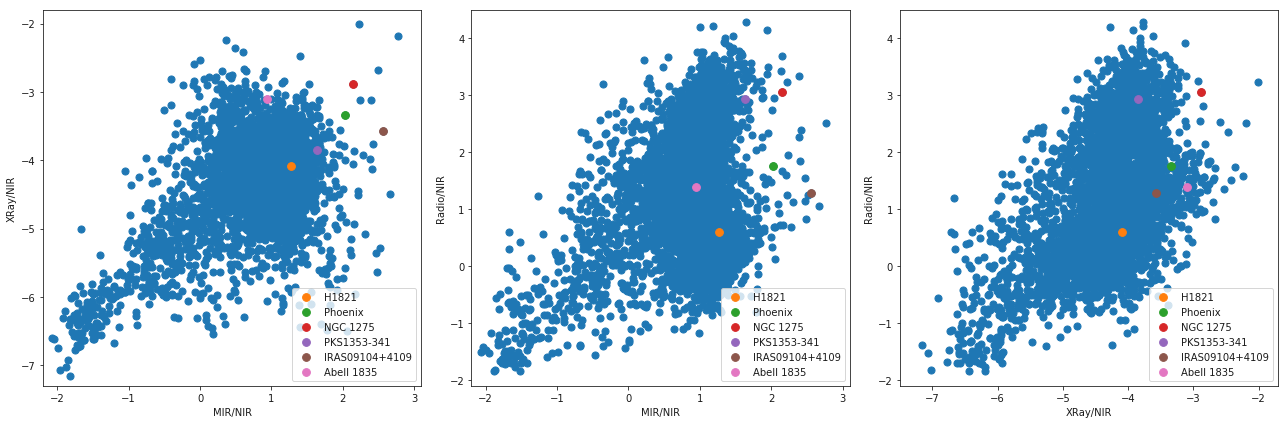

In [691]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))#, sharex="col", sharey="row")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95,hspace=0.1, wspace=0.1)

mir=final['mir'].values
xray=final['xray'].values
radio=final['radio'].values

point=ax[0].scatter(mir,xray,s=50)#,linewidth=0.2,edgecolor='black')
for i, item in enumerate(all_match.keys()):
    ax[0].scatter(all_match[item]['mir'],all_match[item]['xray'],alpha=1.0,label=item,s=60.0)
ax[0].set_xlabel('MIR/NIR')
ax[0].set_ylabel('XRay/NIR')
ax[0].axis([-2.2,3.1,-7.3,-1.8])
ax[0].legend(loc='lower right')

point=ax[1].scatter(mir,radio,s=50)#,linewidth=0.2,edgecolor='black')
for i, item in enumerate(all_match.keys()):
    ax[1].scatter(all_match[item]['mir'],all_match[item]['radio'],alpha=1.0,label=item,s=60.0)
ax[1].set_xlabel('MIR/NIR')
ax[1].set_ylabel('Radio/NIR')
ax[1].axis([-2.2,3.1,-2.1,4.5])
ax[1].legend(loc='lower right')

point=ax[2].scatter(xray,radio,s=50)#,linewidth=0.2,edgecolor='black')
for i, item in enumerate(all_match.keys()):
    ax[2].scatter(all_match[item]['xray'],all_match[item]['radio'],alpha=1.0,label=item,s=60.0)
ax[2].set_xlabel('XRay/NIR')
ax[2].set_ylabel('Radio/NIR')
ax[2].axis([-7.5,-1.7,-2.1,4.5])
ax[2].legend(loc='lower right')

plt.tight_layout()

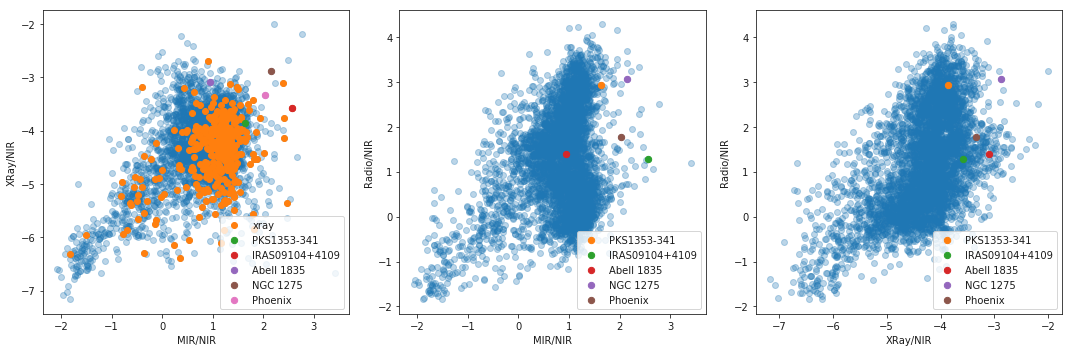

In [343]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))#, sharex="col", sharey="row")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95,hspace=0.1, wspace=0.1)

mir=final['mir'].values
xray=final['xray'].values
radio=final['radio'].values

point=ax[0].scatter(mir,xray,alpha=0.3)
ax[0].scatter(cut_diff['mir'],cut_diff['xray'])
for i, item in enumerate(all_match.keys()):
    ax[0].scatter(all_match[item]['mir'],all_match[item]['xray'],alpha=1.0,label=item,s=40.0)
ax[0].set_xlabel('MIR/NIR')
ax[0].set_ylabel('XRay/NIR')
ax[0].legend(loc='lower right')

point=ax[1].scatter(mir,radio,alpha=0.3)
for i, item in enumerate(all_match.keys()):
    ax[1].scatter(all_match[item]['mir'],all_match[item]['radio'],alpha=1.0,label=item,s=40.0)
ax[1].set_xlabel('MIR/NIR')
ax[1].set_ylabel('Radio/NIR')
ax[1].legend(loc='lower right')

point=ax[2].scatter(xray,radio,alpha=0.3)
for i, item in enumerate(all_match.keys()):
    ax[2].scatter(all_match[item]['xray'],all_match[item]['radio'],alpha=1.0,label=item,s=40.0)
ax[2].set_xlabel('XRay/NIR')
ax[2].set_ylabel('Radio/NIR')
ax[2].legend(loc='lower right')

plt.tight_layout()

In [30]:
#factor of 3 and 9, 9 respectively
#version2: factor of 3.5 and 3.5*3, 3.5*3 respectively
#version3 (12/15/16) mir 3*5, radio 3*3., xray 3

cut1=final
print cut1.shape, cut1.dropna().shape

cut2=final[(final['mir']+final['emir']>all_match['Phoenix']['mir']-np.log10(3*5)) &\
           (final['radio']+final['eradio']>all_match['Phoenix']['radio']-np.log10(3.*3)) &\
           (final['xray']+final['exray']>all_match['Phoenix']['xray']-np.log10(3))]

cut=cut2
# cut=cut[cut['cntr_01']!=11202].set_index([np.arange(1,735+1,1).tolist()])

print cut1.shape, cut.shape

(4500, 61) (4016, 61)
(4500, 61) (791, 61)


In [31]:
cut[(cut['ra_01']>215)&(cut['ra_01']<216)&(cut['dec_01']<-30)]

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,x_f,ex_f,rad_f,erad_f,xray,mir,radio,exray,emir,eradio
cntr_01,,,,,,,,,,,,,,,,,,,,,


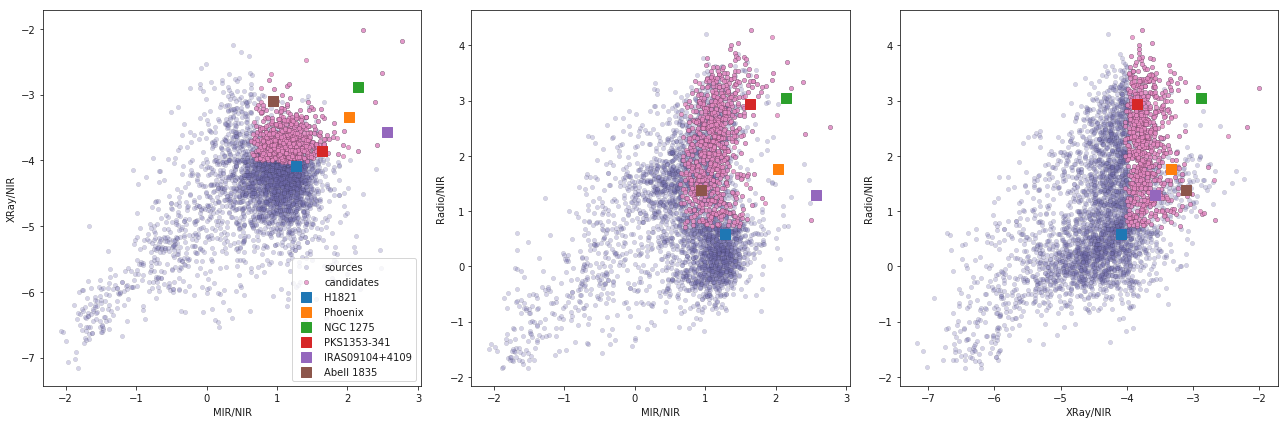

In [694]:
s=6
fig, ax = plt.subplots(1, 3, figsize=(3*s,s))#, sharex="col", sharey="row")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95,hspace=0.1, wspace=0.1)

mir=final.dropna()['mir'].values
xray=final.dropna()['xray'].values
radio=final.dropna()['radio'].values

point=ax[0].scatter(mir,xray,alpha=0.3, c='#7570b3', label='sources',s=20.,linewidth=0.2,edgecolor='black')
ax[0].scatter(cut['mir'],cut['xray'],alpha=0.8,c='#e78ac3',label='candidates',s=20,linewidth=0.2,edgecolor='black')
# ax[0].scatter(cut_diff['mir'],cut_diff['xray'],alpha=0.8,c='tab:green',label='candidates',s=20,linewidth=0.2,edgecolor='black')
for i, item in enumerate(all_match.keys()):
    ax[0].scatter(all_match[item]['mir'],all_match[item]['xray'],alpha=1.0,label=item,s=100.0,marker='s')
ax[0].set_xlabel('MIR/NIR')
ax[0].set_ylabel('XRay/NIR')
ax[0].legend(loc='lower right')

point=ax[1].scatter(mir,radio,alpha=0.3, c='#7570b3', label='sources',s=20.,linewidth=0.2,edgecolor='black')
ax[1].scatter(cut['mir'],cut['radio'],alpha=0.8,c='#e78ac3',label='candidates',s=20,linewidth=0.2,edgecolor='black')
# ax[1].scatter(cut_diff['mir'],cut_diff['radio'],alpha=0.8,c='tab:green',label='candidates',s=20,linewidth=0.2,edgecolor='black')
for i, item in enumerate(all_match.keys()):
    ax[1].scatter(all_match[item]['mir'],all_match[item]['radio'],alpha=1.0,label=item,s=100.0,marker='s')
ax[1].set_xlabel('MIR/NIR')
ax[1].set_ylabel('Radio/NIR')

point=ax[2].scatter(xray,radio,alpha=0.3, c='#7570b3', label='sources',s=20.,linewidth=0.2,edgecolor='black')
ax[2].scatter(cut['xray'],cut['radio'],alpha=0.8,c='#e78ac3',label='candidates',s=20,linewidth=0.2,edgecolor='black')
for i, item in enumerate(all_match.keys()):
    ax[2].scatter(all_match[item]['xray'],all_match[item]['radio'],alpha=1.0,label=item,s=100.0,marker='s')
ax[2].set_xlabel('XRay/NIR')
ax[2].set_ylabel('Radio/NIR')

plt.tight_layout()

# plt.savefig('/Users/taweewat/Documents/chandra/figure/total_object_new.pdf', bbox_inches='tight')

In [699]:
cut.shape

(791, 61)

In [696]:
dfq=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/final_cut6_new.csv')
dfq=dfq.set_index([np.arange(1,735+1,1).tolist()])

In [30]:
def cri_redshift(x):
    if 0.<x<0.1:
        return 'lz'
    elif x>0.7:
        return 'hz'
    else:
        return 'n'
    
dfq["rejectc"]=dfq["redshift"].apply(cri_redshift)
# dfq.rejectc=='n'

In [31]:
c = SkyCoord(ra=['10h38m42.59s'], dec=['+48d49m17.7s'], frame='icrs')
cf = SkyCoord(ra=rosat['ra'].values*u.degree, dec=rosat['dec'].values*u.degree)  
idxn, d2dn, d3dn=c.match_to_catalog_sky(cf)
print idxn, d2dn

NameError: name 'rosat' is not defined

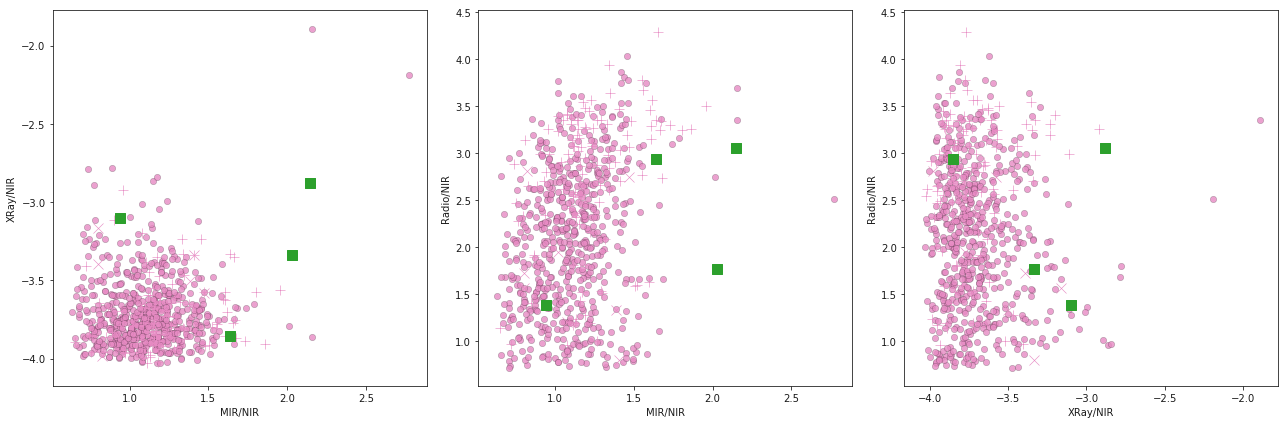

In [148]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))#, sharex="col", sharey="row")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95,hspace=0.1, wspace=0.1)

colors=['#e78ac3','#e78ac3','#e78ac3','#1b9e77','#d95f02','#66a61e','#e3d400']#,'#4868db']
labels=['background','candidates','foreground','Abell 1835','NGC 1275','Phoenix','PKS1353-341']#,'RXJ1727.3+5510']
markers=['+','o','x']
#indi=[ngc_i,phoe_i,target_i]
# indi=[abell_i,ngc_i,phoe_i,pks_i]#,rxj_i]
redshift_type=['hz','n','lz']

# ax[0].scatter(mir,xray,alpha=0.3, c='#7570b3', label='sources',s=20.,linewidth=0.2,edgecolor='black')
ax[0].scatter(dfq[dfq.rejectc=='n']['mir'],dfq[dfq.rejectc=='n']['xray'],alpha=0.8,c='#e78ac3',label='candidates',s=40,linewidth=0.2,edgecolor='black')
ax[0].scatter(dfq[dfq.rejectc=='hz']['mir'],dfq[dfq.rejectc=='hz']['xray'],alpha=1.,c='#e78ac3',label='background',s=100,linewidth=0.6,edgecolor='black',marker='+')
ax[0].scatter(dfq[dfq.rejectc=='lz']['mir'],dfq[dfq.rejectc=='lz']['xray'],alpha=1.,c='#e78ac3',label='background',s=100,linewidth=0.6,edgecolor='black',marker='x')
for i, item in enumerate(all_match.keys()):
    ax[0].scatter(all_match[item]['mir'],all_match[item]['xray'],alpha=1.0,label=item,s=120.0,marker='s',c='tab:green')
ax[0].set_xlabel('MIR/NIR')
ax[0].set_ylabel('XRay/NIR')
# ax[0].legend(loc='best')

ax[1].scatter(dfq[dfq.rejectc=='n']['mir'],dfq[dfq.rejectc=='n']['radio'],alpha=0.8,c='#e78ac3',label='candidates',s=40,linewidth=0.2,edgecolor='black')
ax[1].scatter(dfq[dfq.rejectc=='hz']['mir'],dfq[dfq.rejectc=='hz']['radio'],alpha=1.,c='#e78ac3',label='background',s=100,linewidth=0.6,edgecolor='black',marker='+')
ax[1].scatter(dfq[dfq.rejectc=='lz']['mir'],dfq[dfq.rejectc=='lz']['radio'],alpha=1.,c='#e78ac3',label='background',s=100,linewidth=0.6,edgecolor='black',marker='x')
for i, item in enumerate(all_match.keys()):
    ax[1].scatter(all_match[item]['mir'],all_match[item]['radio'],alpha=1.0,label=item,s=120.0,marker='s',c='tab:green')
ax[1].set_xlabel('MIR/NIR')
ax[1].set_ylabel('Radio/NIR')

ax[2].scatter(dfq[dfq.rejectc=='n']['xray'],dfq[dfq.rejectc=='n']['radio'],alpha=0.8,c='#e78ac3',label='candidates',s=40,linewidth=0.2,edgecolor='black')
ax[2].scatter(dfq[dfq.rejectc=='hz']['xray'],dfq[dfq.rejectc=='hz']['radio'],alpha=1.,c='#e78ac3',label='background',s=100,linewidth=0.6,edgecolor='black',marker='+')
ax[2].scatter(dfq[dfq.rejectc=='lz']['xray'],dfq[dfq.rejectc=='lz']['radio'],alpha=1.,c='#e78ac3',label='background',s=100,linewidth=0.6,edgecolor='black',marker='x')
for i, item in enumerate(all_match.keys()):
    ax[2].scatter(all_match[item]['xray'],all_match[item]['radio'],alpha=1.0,label=item,s=120.0,marker='s',c='tab:green')
ax[2].set_xlabel('XRay/NIR')
ax[2].set_ylabel('Radio/NIR')

# ax[1].scatter(0.712896,2.121039,c='red',s=100)

plt.tight_layout()
# #plugins.connect(fig, plugins.LinkedBrush(point))

# plt.savefig('/Users/taweewat/Documents/chandra/figure/560_object_new.pdf', bbox_inches='tight')

In [154]:
# dfq[(dfq['ra']<186.5)&(dfq['ra']>186.4)]
# dfq[dfq['SDSS']=='yes']

NameError: name 'dfq' is not defined

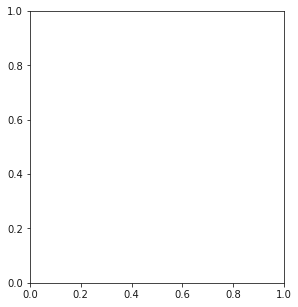

In [695]:
plt.figure(figsize=(10,5))

for i in range(2):
    if i==0:
        band='xray'
    elif i==1:
        band='radio'
        
    plt.subplot(1,2,i+1)
    plt.scatter(dfq[dfq.rejectc=='n']['w1mpro']-dfq[dfq.rejectc=='n']['w2mpro'],dfq[dfq.rejectc=='n'][band],alpha=0.8,c='#e78ac3',label='candidates',s=40,linewidth=0.2,edgecolor='black')
    plt.scatter(all_match_df['w1mpro']-all_match_df['w2mpro'],all_match_df[band],alpha=1.0,label=item,s=120.0,marker='s',c='tab:green')
    plt.axvline(0.8)
    for i, txt in enumerate(all_match_df['index'].values):
        plt.annotate(txt,(all_match_df.iloc[i]['w1mpro']-all_match_df.iloc[i]['w2mpro'],\
                          all_match_df.iloc[i][band]))
    plt.xlabel('W1-W2')
    plt.ylabel('%s/NIR'%band)
plt.tight_layout()

In [105]:
all_match_df[(all_match_df['w1mpro']-all_match_df['w2mpro'])>0.8]

,index,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,...,exray,emir,eradio,redshift,sep,type,SDSS,reject,followup,rejectc
1,NGC 1275,10010,12.995907,138.868914,49.94750,41.51445,49.950671,41.511731,0.0291,0.0277,...,0.024935,0.025122,0.027653,0.01790,5.5,GClstr,yes,reject,inSD/outside,lz
2,PKS1353-341,11452,26.725984,169.371199,209.02083,-34.34570,209.022489,-34.352997,0.0397,0.0394,...,0.137578,0.066543,0.065897,-1.00000,-1.0,NaN,no,not_reject,follow,n
3,Phoenix,13799,7.376192,-16.624494,356.18375,-42.72208,356.182952,-42.720117,0.0347,0.0348,...,0.112105,0.050920,0.051990,0.59732,7.5,G,no,not_reject,follow,n


<hr>

## NED 
URL: https://ned.ipac.caltech.edu/forms/nnd.html seperation: 15"

In [700]:
df_sd=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/total_sdss.csv',index_col=0)
print (df_sd.loc[:100,['ra','dec']]).to_csv(sep='\t', index=False)

ra	dec
34.37958	73.82569
114.08708	65.2232
145.94792	69.14014
175.36624	65.61042
263.22708	65.55666
193.50043	62.7175
193.88333	59.66583
220.38042	60.31264
266.25665	59.6775
146.89792	58.51431
199.88083	55.13903
209.57083	57.86986
207.40125	53.68958
228.82793	55.26139
242.31252	53.90931
122.9	48.52306
155.76459	50.68681
155.18417	49.34347
151.31833	48.09583
167.77333	52.4675
179.87	52.095
195.57292	48.32444
228.79916	47.91417
236.26208	51.58472
266.20917	51.06597
140.80084	46.04681
171.73459	45.27139
177.79625	47.48653
196.61583	47.69333
214.28375	46.11611
220.55376	42.87194
254.51251	47.62722
106.88541	38.37111
136.41374	41.42861
139.76416	40.27986
147.23543	40.66639
182.85666	40.89514
181.65459	39.68847
187.19624	37.10417
202.97833	40.54111
214.41417	38.30695
215.27541	38.9225
245.62457	40.10931
335.13251	39.80764
18.05792	35.37042
28.51958	32.74611
116.49542	33.22181
118.36958	33.8475
124.46417	32.72417
150.72334	32.67903
153.61792	31.07181
161.58792	34.45625
164.27417	31.32278
187.

In [234]:
headers=['1','2','ra_dec','sep','3','name','ra_h','dec_h','type','redshift','4','5']
dff=pd.read_csv('/Users/taweewat/Documents/xray_project/candidate_sdss_new.txt', keep_default_na=True, sep="|",\
                skiprows=0,names=headers)
dff=dff[4:]
print dff.shape
df2=dff.loc[dff['ra_dec']!='                              ']
df2.duplicated('ra_dec')
print df2.shape

dff['ra']=[i.strip().split(' ')[0] for i in dff['ra_dec'].values]
dff['dec']=[i.strip().split(' ')[-1] for i in dff['ra_dec'].values]
dff['redshift']=[i.strip() for i in dff['redshift'].values]

redshift_a=np.zeros(df2.shape[0])-1
sep_a=np.zeros(df2.shape[0])-1
type_a=["" for x in range(df2.shape[0])]

i_df=-1
for index, row in dff.iterrows():
    if row['ra']!='':
        i_df+=1
        if row['redshift']!='':
            redshift_a[i_df]=row['redshift']        
            sep_a[i_df]=row['sep']
            type_a[i_df]=row['type']
    elif row['ra']=='':
        if row['redshift']!='':
            if redshift_a[i_df]==-1:
                redshift_a[i_df]=row['redshift']
                sep_a[i_df]=row['sep']
                type_a[i_df]=row['type']

(1338, 12)
(374, 12)


In [235]:
df_sd.shape, redshift_a.shape

((374, 69), (374,))

In [236]:
df_sd['redshift']=redshift_a
df_sd.loc[:,'sep']=sep_a
df_sd.loc[:,'type']=type_a

In [242]:
sep_a[0]

1.2

In [238]:
df_sd.to_csv('/Users/taweewat/Documents/xray_project/ned-result/total_sdss_ned.csv')

## --- NEDS for Cut

In [701]:
cut.head()

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,x_f,ex_f,rad_f,erad_f,xray,mir,radio,exray,emir,eradio
cntr_01,,,,,,,,,,,,,,,,,,,,,
55,6.526185,-8.858947,133.04916,76.45306,133.047968,76.454851,0.0422,0.0421,-0.0066,13.827,...,7.050360e-31,2.001799e-31,1.906000e-24,6.500000e-26,-3.938519,1.181296,2.493392,0.133939,0.070364,0.054538
145,1.098727,-83.546683,34.37958,73.82569,34.378491,73.825724,0.0482,0.0477,-0.0040,14.024,...,6.978417e-31,1.595144e-31,2.271000e-23,6.810000e-25,-3.872174,1.345296,3.640287,0.116648,0.070748,0.062726
173,6.014274,151.687668,137.11916,72.27611,137.121762,72.274639,0.0444,0.0444,-0.0020,14.167,...,5.609712e-31,1.881295e-31,3.178000e-24,9.500000e-26,-3.838990,1.457696,2.914223,0.165112,0.089741,0.079033
188,6.771788,-26.052877,156.65541,70.54361,156.652929,70.545300,0.0482,0.0488,0.0041,14.223,...,6.210432e-31,2.205036e-31,1.351000e-24,4.100000e-26,-3.864009,1.146896,2.473525,0.172692,0.092658,0.079065
321,11.401083,168.222225,114.08708,65.22320,114.088622,65.220100,0.0653,0.0663,0.0023,14.722,...,4.275180e-31,1.960432e-31,8.400000e-25,3.000000e-26,-3.978176,1.131696,2.315149,0.211735,0.111482,0.073924


In [702]:
cut=cut.set_index([np.arange(1,len(cut)+1,1).tolist()])

In [719]:
cut.shape

(791, 61)

In [715]:
#prepare value for NED search by creating list of RA and DEC sutiable for the search
print (cut.loc[700:,['ra','dec']]).to_csv(sep='\t', index=False)

ra	dec
7.87167	-41.13708
21.81167	-41.21222
35.57167	-41.9925
1.14375	-47.61069
23.30792	-43.9782
25.97042	-44.40514
166.78792	-44.81833
169.61	-46.57222
184.52791	-46.01042
203.57376	-46.43486
212.58458	-42.79042
269.46332	-45.58389
289.42126	-45.50361
314.06586	-47.24611
321.95502	-47.42583
347.22	-45.96375
347.87958	-47.31264
12.68417	-52.81931
19.70542	-48.3532
37.36	-52.53667
62.91375	-51.82708
102.12041	-48.13167
309.59039	-48.055
316.25168	-48.81139
349.25708	-52.17153
6.29208	-54.46389
47.27708	-57.39208
300.56042	-58.62986
334.83835	-56.33792
343.45541	-58.77153
20.41542	-63.15055
45.9625	-62.19097
300.94086	-63.00597
341.36667	-59.92347
353.45541	-61.73736
32.36708	-68.17236
58.93875	-66.76195
55.11209	-67.05569
313.02832	-65.39125
344.63333	-70.24292
279.37665	-71.13958
5.49667	-51.67458
6.03417	-68.34875
12.32208	-44.95347
14.37417	-41.97458
14.69958	-56.9868
15.89042	-64.65694
28.12708	-50.4743
31.66875	-71.80625
34.76	-36.43681
35.37	-47.21583
39.2225	-61.60556
43.36792	-

In [753]:
headers=['1','2','ra_dec','sep','3','name','ra_h','dec_h','type','redshift','4','5']
# dff=pd.read_csv('/Users/taweewat/Documents/xray_project/candidate_735_v6_new.txt', keep_default_na=True, sep="|",\
#                 skiprows=0,names=headers)
dff=pd.read_csv('/Users/taweewat/Documents/xray_project/candidate_791_v7_new.txt', keep_default_na=True, sep="|",\
                skiprows=0,names=headers)
dff=dff[4:]
print dff.shape
df2=dff.loc[dff['ra_dec']!='                              ']
df2.duplicated('ra_dec')
print df2.shape
df2.index=np.arange(1,len(df2)+1,1)
# df2.tail()

(2421, 12)
(791, 12)


In [754]:
cutdf2=pd.concat([cut,df2], axis=1,join='inner')

In [755]:
dff['ra']=[i.strip().split(' ')[0] for i in dff['ra_dec'].values]
dff['dec']=[i.strip().split(' ')[-1] for i in dff['ra_dec'].values]
dff['redshift']=[i.strip() for i in dff['redshift'].values]

redshift_a=np.zeros(df2.shape[0])-1
sep_a=np.zeros(df2.shape[0])-1
type_a=["" for x in range(df2.shape[0])]

i_df=-1
for index, row in dff.iterrows():
    if row['ra']!='':
        i_df+=1
        if row['redshift']!='':
            redshift_a[i_df]=row['redshift']        
            sep_a[i_df]=row['sep']
            type_a[i_df]=row['type']
    elif row['ra']=='':
        if row['redshift']!='':
            if redshift_a[i_df]==-1:
                redshift_a[i_df]=row['redshift']
                sep_a[i_df]=row['sep']
                type_a[i_df]=row['type']

In [756]:
cut['redshift']=redshift_a
cut.loc[:,'sep']=sep_a
cut.loc[:,'type']=type_a

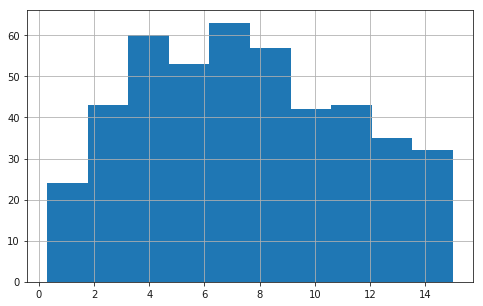

In [757]:
cut.loc[cut['sep']!=-1,'sep'].hist()

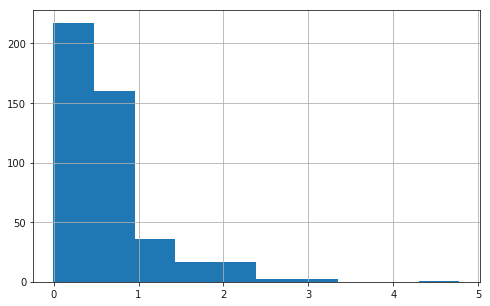

In [758]:
cut.loc[cut['sep']!=-1,'redshift'].hist()

## SDSS

In [759]:
x=urllib2.urlopen("http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=101.25618917&dec=60.41442889&scale=0.20&width=400&height=400&opt=OG")
empty_file=x.read()

scale=0.2
width=400
height=400

sdss=[]
for i in np.arange(1,len(cut['ra'])+1,1):
    RA=cut['ra'][i]
    DEC=cut['dec'][i]
    url = ("http://skyservice.pha.jhu.edu/DR13/ImgCutout/"
           "getjpeg.aspx?ra=%.8f&dec=%.8f&scale=%.2f&width=%i&height=%i&opt=OG"%(RA, DEC, scale, width, height))
    print url
    page=urllib2.urlopen(url)
    img=page.read()
    if img==empty_file:
        print 'empty'
        sdss.append('no')
    else:
        print 'image'
        sdss.append('yes')

http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=133.04916000&dec=76.45306000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=34.37958000&dec=73.82569000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=137.11916000&dec=72.27611000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=156.65541000&dec=70.54361000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=114.08708000&dec=65.22320000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=145.94792000&dec=69.14014000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=175.36624000&dec=65.61042000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.asp

image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=116.49542000&dec=33.22181000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=118.36958000&dec=33.84750000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=124.46417000&dec=32.72417000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=150.72334000&dec=32.67903000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=153.61792000&dec=31.07181000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=161.58792000&dec=34.45625000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=164.27417000&dec=31.32278000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getj

image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=60.20750000&dec=19.67306000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=80.29208000&dec=16.63889000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=124.64458000&dec=18.49667000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=152.07834000&dec=19.55097000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=192.02959000&dec=18.63694000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=190.99042000&dec=16.38153000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=221.67209000&dec=14.46486000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpe

empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=340.29208000&dec=-5.41069000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=349.99081000&dec=-5.11500000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=358.71582000&dec=-4.08208000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=14.37167000&dec=-9.54972000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=12.61167000&dec=-12.01708000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=19.05250000&dec=-11.60778000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=16.88750000&dec=-13.17986000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjp

empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=4.90000000&dec=-26.84431000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=10.21500000&dec=-29.03375000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=18.03917000&dec=-29.31847000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=28.35750000&dec=-28.93819000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=41.01167000&dec=-28.65639000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=56.76875000&dec=-25.77847000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=66.73292000&dec=-27.92945000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjp

image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=5.25375000&dec=-24.84639000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=5.81708000&dec=-14.38361000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=6.12708000&dec=-29.48236000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=6.47292000&dec=8.62347000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=6.62583000&dec=-8.70639000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=6.63083000&dec=-18.66736000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=8.92208000&dec=-18.28153000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?r

empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=47.60125000&dec=39.18583000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=48.25834000&dec=41.33528000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=49.94750000&dec=41.51445000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=54.12625000&dec=32.30847000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=54.57250000&dec=22.73056000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=55.52250000&dec=-37.05305000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=57.16042000&dec=-27.81847000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.a

image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=133.71249000&dec=62.31208000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=136.38918000&dec=18.66972000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=136.52042000&dec=19.69806000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=136.63333000&dec=16.77194000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=136.93584000&dec=53.40611000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=137.35124000&dec=52.27500000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=138.14876000&dec=-9.94014000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getj

image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=170.09125000&dec=11.07556000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=172.78709000&dec=31.23597000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=173.24750000&dec=10.39583000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=173.61833000&dec=41.79736000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=174.14958000&dec=6.51917000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=174.79333000&dec=-13.84083000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=174.90292000&dec=3.88708000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjp

image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=206.00584000&dec=-9.41111000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=206.53043000&dec=73.34361000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=207.69041000&dec=23.52944000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=208.25000000&dec=29.79500000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=208.40083000&dec=26.53014000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=208.42375000&dec=43.18319000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=208.69624000&dec=-10.68333000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/get

image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=263.26126000&dec=-13.08097000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=264.12292000&dec=34.68375000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=264.23248000&dec=45.27056000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=265.52960000&dec=18.45555000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=267.88000000&dec=47.22097000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=268.05167000&dec=43.69042000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=270.00958000&dec=28.17847000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/get

image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=343.54126000&dec=24.75639000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=343.85834000&dec=30.41986000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=345.76541000&dec=-18.69194000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=346.72708000&dec=-34.65264000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=347.54208000&dec=10.79208000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=348.29041000&dec=-31.97111000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=351.52750000&dec=-4.46944000&scale=0.20&width=400&height=400&opt=OG
image
http://skyservice.pha.jhu.edu/DR13/ImgCutout/g

empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=14.69958000&dec=-56.98680000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=15.89042000&dec=-64.65694000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=28.12708000&dec=-50.47430000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=31.66875000&dec=-71.80625000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=34.76000000&dec=-36.43681000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=35.37000000&dec=-47.21583000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getjpeg.aspx?ra=39.22250000&dec=-61.60556000&scale=0.20&width=400&height=400&opt=OG
empty
http://skyservice.pha.jhu.edu/DR13/ImgCutout/getj

In [766]:
cut.loc[:,'SDSS']=sdss

In [767]:
def reject_redshift(x):
    if x==-1 or (x>=0.1 and x<=0.7):
        return 'not_reject'
    else:
        return 'reject'
     
def follow(row):
    if row['SDSS']=='no' and row['reject']=='not_reject':
        return 'follow'
    if row['SDSS']=='yes' and row['reject']=='not_reject':
        return 'followed'
    if row['SDSS']=='no' and row['reject']=='reject':
        return 'outSD/outside'
    if row['SDSS']=='yes' and row['reject']=='reject':
        return 'inSD/outside'

cut.loc[:,'reject']=cut['redshift'].apply(reject_redshift)
cut.loc[:,'followup']=cut.apply(follow, axis=1)

In [768]:
cut

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,radio,exray,emir,eradio,redshift,sep,type,SDSS,reject,followup
1,6.526185,-8.858947,133.04916,76.45306,133.047968,76.454851,0.0422,0.0421,-0.0066,13.827,...,2.493392,0.133939,0.070364,0.054538,1.127000,7.2,G,no,reject,outSD/outside
2,1.098727,-83.546683,34.37958,73.82569,34.378491,73.825724,0.0482,0.0477,-0.0040,14.024,...,3.640287,0.116648,0.070748,0.062726,2.367000,1.2,QSO,yes,reject,inSD/outside
3,6.014274,151.687668,137.11916,72.27611,137.121762,72.274639,0.0444,0.0444,-0.0020,14.167,...,2.914223,0.165112,0.089741,0.079033,-1.000000,-1.0,,no,not_reject,follow
4,6.771788,-26.052877,156.65541,70.54361,156.652929,70.545300,0.0482,0.0488,0.0041,14.223,...,2.473525,0.172692,0.092658,0.079065,-1.000000,-1.0,,no,not_reject,follow
5,11.401083,168.222225,114.08708,65.22320,114.088622,65.220100,0.0653,0.0663,0.0023,14.722,...,2.315149,0.211735,0.111482,0.073924,3.035000,11.8,QSO,yes,reject,inSD/outside
6,6.443767,-156.930035,145.94792,69.14014,145.945950,69.138493,0.0501,0.0512,0.0050,14.451,...,1.234199,0.246976,0.136120,0.114307,1.598200,6.6,QSO,yes,reject,inSD/outside
7,16.654796,-156.066080,175.36624,65.61042,175.361696,65.606191,0.0391,0.0390,-0.0046,13.478,...,3.068277,0.191132,0.079745,0.077005,-1.000000,-1.0,,yes,not_reject,followed
8,3.378750,-69.361073,263.22708,65.55666,263.224957,65.556991,0.0382,0.0401,-0.0077,14.062,...,3.161672,0.095879,0.090274,0.086623,0.885000,3.3,*,yes,reject,inSD/outside
9,12.770218,-81.392609,98.97625,61.35931,98.968932,61.359841,0.1013,0.1088,-0.0160,15.499,...,1.401197,0.199632,0.205785,0.085604,-1.000000,-1.0,,no,not_reject,follow
10,7.520648,-135.255349,193.50043,62.71750,193.497222,62.716016,0.0440,0.0450,-0.0047,13.846,...,1.402017,0.145450,0.120427,0.067117,0.867000,7.7,QSO,yes,reject,inSD/outside


In [769]:
print cut['followup'].value_counts()
print cut['SDSS'].value_counts()

follow           332
followed         302
inSD/outside      99
outSD/outside     58
Name: followup, dtype: int64
yes    401
no     390
Name: SDSS, dtype: int64


follow           303
followed         291
inSD/outside      87
outSD/outside     54
Name: followup, dtype: int64
yes    378
no     357
Name: SDSS, dtype: int64


[332, 302, 157]


(0, 350)

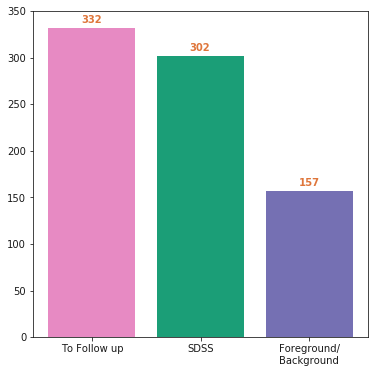

In [770]:
fig = plt.subplots(figsize=(6,6))
x = cut['followup'].value_counts()
head=['To Follow up','SDSS','Foreground/\nBackground']
value=[x.values[0],x.values[1],x.values[2]+x.values[3]]
print value

plt.bar(range(len(head)), value, align='center', color=['#e78ac3','#1b9e77','#7570b3'])
plt.xticks(range(len(head)), head, size='medium')
for i in range(len(head)):
    plt.text(i-0.1,value[i]+5,value[i],color='#DF763B',family='sans-serif',weight='bold')
plt.ylim(0,350)
#plt.savefig('/Users/taweewat/Documents/chandra/figure/barchart.pdf', bbox_inches='tight')

In [786]:
cut.to_csv('/Users/taweewat/Documents/xray_project/ned-result/final_cut_791_new.csv', index=False)

In [25]:
# cut=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/final_cut_791_new.csv')

In [774]:
final0=cut[cut['followup']=='follow']

## Start the analysis by removing mike sample

In [787]:
final0=cut
# final0=dfq

In [19]:
#read in mike objects
mike=pd.read_csv('/Users/taweewat/Dropbox/Documents/MIT/Observation/2017_1/mike_previous_observing.txt',delim_whitespace=True,header=None,names=['index','name','ra','dec'])
mike['RA0']=[float(Angle(i, u.hr).to_string(unit=u.degree, precision=5, decimal=True)) for i in mike.ra]
mike['DEC0']=[float(Angle(i, u.deg).to_string(unit=u.degree, precision=5, decimal=True)) for i in mike.dec]

In [789]:
match=np.array([(((final0.loc[:,'ra']-mike.RA0[i])**2+(final0.loc[:,'dec']-mike.DEC0[i])**2)**0.5).min() for i in range(mike.shape[0])])<0.1
print match
duplicate_id=np.array([(((final0.loc[:,'ra']-mike.RA0[i])**2+(final0.loc[:,'dec']-mike.DEC0[i])**2)**0.5).idxmin() for i in range(mike.shape[0])])[match]
print duplicate_id

[ True  True  True  True  True  True False  True  True  True  True False
 False  True False False False False  True False  True  True]
[385 391 426 567 555 546 443 199 104 556 759 427 768 770]


In [790]:
np.array([(((final0.loc[:,'ra']-mike.RA0[i])**2+(final0.loc[:,'dec']-mike.DEC0[i])**2)**0.5).min() for i in range(mike.shape[0])])

array([  1.05309069e-03,   5.20818586e-03,   1.62409975e-03,
         7.54708553e-03,   2.16372364e-03,   1.86488606e-03,
         4.73677638e+00,   6.01082357e-04,   2.50000000e-03,
         2.22000000e-03,   1.99692263e-03,   1.96304221e+00,
         5.58480284e+00,   4.16635332e-03,   8.86664021e+00,
         1.08679552e+01,   1.53441149e+00,   3.28014530e+00,
         2.81154762e-03,   4.13086566e+00,   3.34175104e-03,
         9.30215029e-04])

In [791]:
mike[match]

,index,name,ra,dec,RA0,DEC0
0,8,2DFGRSS833Z409,04:15:24.0,-23:22:34,63.85000,-23.37611
1,9,NVSSJ0444-2642,04:44:32.9,-26:42:52,71.13708,-26.71444
2,10,RXJ0825.8+0309,08:25:50.4,+03:09:25,126.46000,3.15694
3,6,PKS1353-341,13:56:05.4,-34:21:11,209.02250,-34.35306
4,12,HB89-1334-127,13:37:39.8,-12:57:25,204.41583,-12.95694
5,11,SDSSJ130412+044017,13:04:12.3,+04:40:17,196.05125,4.67139
7,24,6DFJ0912355-095623,09:12:35.6,-09:56:23,138.14833,-9.93972
8,32,NVSSJ085058-085314,08:50:58.6,-08:53:15,132.74417,-8.88750
9,13,FBQSJ095650+251515,09:56:49.9,+25:15:16,149.20792,25.25444
10,30,6DFJ1340435-281105,13:40:43.6,-28:11:05,205.18167,-28.18472


In [792]:
print final0.shape
print final0.drop(duplicate_id).shape
final1=final0.drop(duplicate_id)

(791, 67)
(777, 67)


In [793]:
final1.to_csv('/Users/taweewat/Documents/xray_project/ned-result/final_cut7_new.csv', index=False)

In [796]:
dfq=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/final_cut7_new.csv')
dfq=dfq.set_index([np.arange(1,777+1,1).tolist()])

In [797]:
# cutq=cut[cut['cntr_01']!=11202].set_index([np.arange(1,735+1,1).tolist()])
# cutq

In [879]:
dfq.shape

(777, 68)

In [880]:
ra_l=[Angle(i, u.deg).to_string(unit=u.hr, sep='', precision=0, pad=True)[:4] for i in dfq['ra'].values]
dec_l=[Angle(i, u.deg).to_string(unit=u.degree, sep='', precision=0, alwayssign=True, pad=True)[:5] for i in dfq['dec'].values]

dfq['chips']=['CHIPS'+i+j for i, j in zip(ra_l, dec_l)]

In [885]:
dfq=dfq.drop(dfq[dfq['chips']=='CHIPS0133+3039'].index) #M33
dfq.shape

(776, 68)

In [886]:
dfq.to_csv('/Users/taweewat/Dropbox/Documents/MIT/Observation/chips_name_new_776.csv')

In [891]:
dfq.head()

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,exray,emir,eradio,redshift,sep,type,SDSS,reject,followup,chips
1,6.526185,-8.858947,133.04916,76.45306,133.047968,76.454851,0.0422,0.0421,-0.0066,13.827,...,0.133939,0.070364,0.054538,1.127,7.2,G,no,reject,outSD/outside,CHIPS0852+7627
2,1.098727,-83.546683,34.37958,73.82569,34.378491,73.825724,0.0482,0.0477,-0.0040,14.024,...,0.116648,0.070748,0.062726,2.367,1.2,QSO,yes,reject,inSD/outside,CHIPS0217+7349
3,6.014274,151.687668,137.11916,72.27611,137.121762,72.274639,0.0444,0.0444,-0.0020,14.167,...,0.165112,0.089741,0.079033,-1.000,-1.0,NaN,no,not_reject,follow,CHIPS0908+7216
4,6.771788,-26.052877,156.65541,70.54361,156.652929,70.545300,0.0482,0.0488,0.0041,14.223,...,0.172692,0.092658,0.079065,-1.000,-1.0,NaN,no,not_reject,follow,CHIPS1026+7032
5,11.401083,168.222225,114.08708,65.22320,114.088622,65.220100,0.0653,0.0663,0.0023,14.722,...,0.211735,0.111482,0.073924,3.035,11.8,QSO,yes,reject,inSD/outside,CHIPS0736+6513


In [890]:
total.head()

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,eradio,redshift,sep,type,SDSS,reject,followup,chips,pisco,panstar
0,6.526185,-8.858947,133.04916,76.45306,133.047968,76.454851,0.0422,0.0421,-0.0066,13.827,...,0.054538,1.1270,7.2,G,no,reject,outSD/outside,CHIPS0852+7627,False,True
2,6.014274,151.687668,137.11916,72.27611,137.121762,72.274639,0.0444,0.0444,-0.0020,14.167,...,0.079033,-1.0000,-1.0,NaN,no,not_reject,follow,CHIPS0908+7216,False,True
3,6.771788,-26.052877,156.65541,70.54361,156.652929,70.545300,0.0482,0.0488,0.0041,14.223,...,0.079065,-1.0000,-1.0,NaN,no,not_reject,follow,CHIPS1026+7032,False,True
4,11.401083,168.222225,114.08708,65.22320,114.088622,65.220100,0.0653,0.0663,0.0023,14.722,...,0.073924,3.0350,11.8,QSO,yes,reject,inSD/outside,CHIPS0736+6513,False,True
5,6.443767,-156.930035,145.94792,69.14014,145.945950,69.138493,0.0501,0.0512,0.0050,14.451,...,0.114307,1.5982,6.6,QSO,yes,reject,inSD/outside,CHIPS0943+6908,False,True


<hr>

In [14]:
dff=pd.read_csv('/Users/taweewat/Dropbox/Documents/MIT/Observation/chips_name_new_776.csv',index_col=0)

In [18]:
dff[(dff['ra_01']>215)&(dff['ra_01']<216)]

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,exray,emir,eradio,redshift,sep,type,SDSS,reject,followup,chips
55,2.093178,-20.784220,215.27541,38.92250,215.275145,38.923044,0.0412,0.0409,-0.0062,13.839,...,0.125389,0.072363,0.067506,0.489165,2.0,QSO,yes,not_reject,followed,CHIPS1421+3855
265,17.891305,-68.578506,215.71042,-27.46764,215.705206,-27.465825,0.0466,0.0463,-0.0077,13.629,...,0.156794,0.095462,0.071902,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS1422-2728
267,18.093469,-169.203907,215.08458,-29.06278,215.083503,-29.067717,0.0515,0.0526,0.0033,14.038,...,0.175590,0.128019,0.070677,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS1420-2903
570,7.448716,89.660890,215.80583,50.92708,215.809113,50.927092,0.0344,0.0346,-0.0057,12.622,...,0.046464,0.040354,0.040279,0.276217,7.4,G,yes,not_reject,followed,CHIPS1423+5055


In [806]:
print np.min(dff.xc), np.min(dff.w4mpro), np.min(dff.k_m_2mass), np.min(dff.rad_f)

0.01311 1.152 9.976 2.3e-26


In [807]:
print np.min(dff.xc), np.min(dff.w4mpro), np.min(dff.k_m_2mass), np.min(dff.rad_f)
print np.min(dff.x_f), np.min(dff.wi_f), np.min(dff.wi0_f), np.min(dff.rad_f)

0.01311 1.152 9.976 2.3e-26
2.35791366906e-31 1.65510766104e-26 1.93878858974e-27 2.3e-26


In [808]:
dff[dff.chips=='CHIPS2344-4243'][['x_f','wi_f','wi0_f','rad_f']]

,x_f,wi_f,wi0_f,rad_f
773,3.794964e-30,8.815080e-25,8.247654e-27,4.768971e-25


In [ ]:
dff

In [2]:
df=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/final_cut7_new.csv'); print len(df)

722


In [206]:
np.sum(df2['SDSS']=='no')

294

In [809]:
df2=pd.read_csv('/Users/taweewat/Documents/red_sequence/chips_all_obj.csv', index_col=0); print len(df2)

294


In [4]:
np.sum(df2.panstar==True)

186

In [5]:
np.sum(df2.pisco==True)

88

In [6]:
np.sum(df.SDSS=='yes')

374

In [7]:
np.sum(df.followup=='follow')

294

In [8]:
np.sum(df.followup=='followed')

288

In [9]:
np.sum(df.followup=='outSD/outside')

54

In [10]:
np.sum(df2.panstar==True)

186

In [11]:
np.sum(df2.SDSS=='no')

294

In [25]:
pheo_coord=SkyCoord(ra=356.18307*u.degree,dec=-42.720204*u.degree)
c5 = SkyCoord(ra=df['ra_01'].values*u.degree, dec=df['dec_01'].values*u.degree)
sep = c5.separation(pheo_coord)
pheo2=df.loc[np.argmin(sep)]

NameError: name 'df' is not defined

## Start the new analysis

In [23]:
lims=[1.9,2.5,2.8]
def func_prior(row, lims, pheo2):
# a function to craete a priority column for the data
    if (row['mir']+row['emir']>pheo2['mir']-np.log10(lims[0]*5.))&\
    (row['radio']+row['eradio']>pheo2['radio']-np.log10(lims[0]*3.))&\
    (row['xray']+row['exray']>pheo2['xray']-np.log10(lims[0])):
        return 1
    elif (row['mir']+row['emir']>pheo2['mir']-np.log10(lims[1]*5.))&\
    (row['radio']+row['eradio']>pheo2['radio']-np.log10(lims[1]*3.))&\
    (row['xray']+row['exray']>pheo2['xray']-np.log10(lims[1])):
        return 2
    elif (row['mir']+row['emir']>pheo2['mir']-np.log10(lims[2]*5.))&\
    (row['radio']+row['eradio']>pheo2['radio']-np.log10(lims[2]*3.))&\
    (row['xray']+row['exray']>pheo2['xray']-np.log10(lims[2])):
        return 3
    else:
        return 4

In [24]:
total=pd.read_csv('/Users/taweewat/Documents/red_sequence/chips_all_obj.csv',index_col=0)

total['priority2']=total.apply(func_prior, args=(lims, pheo2,), axis=1)
total['pisco_all']=False
total['name']=False

NameError: name 'pheo2' is not defined

Text(0,0.5,'X-Ray/NIR')

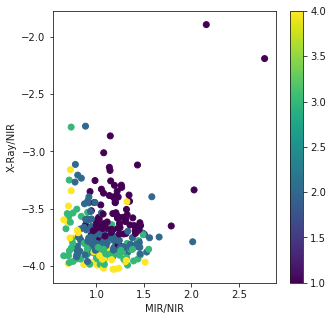

In [17]:
plt.figure(figsize=(5,5))
plt.scatter(total['mir'],total['xray'],c=total['priority2'])
plt.colorbar()
plt.xlabel('MIR/NIR')
plt.ylabel('X-Ray/NIR')
# total.columns

In [3]:
def find_ra_dec(field):
    if field == 'PKS1353':
        RA = 209.0225
        DEC = -34.3530556
        redshift = 0.223
    elif field == 'CHIPS2249-2808': #CHIPS2227-4333
#         RA = 336.99975202151825
#         DEC = -43.57623068466675
        RA = 336.98001
        DEC = -43.56472
        redshift = -1
    elif field == 'CHIPS2246-2854': #'CHIPS2223-3455'
#         RA = 335.7855174238757
#         DEC = -34.934569299688185
        RA = 335.78
        DEC = -34.9275
        redshift = -1
    elif field[0:5] == 'Field':
        base = pd.read_csv(
            '/Users/taweewat/Dropbox/Documents/MIT/Observation/2017_1/all_objs.csv')
        RA = base[base.name == field].ra.values[0]
        DEC = base[base.name == field].dec.values[0]
        redshift = base[base.name == field].redshift.values[0]
    elif field[0:5] == 'CHIPS':
        base = pd.read_csv(
            '/Users/taweewat/Documents/red_sequence/chips_all_obj.csv', index_col=0)
        RA = base[base.chips == field].ra.values[0]
        DEC = base[base.chips == field].dec.values[0]
        redshift = base[base.chips == field].redshift.values[0]
    elif field[0:4] == 'SDSS':
        base = pd.read_csv(
            '/Users/taweewat/Documents/xray_project/ned-result/final_sdss_cut5.csv', index_col=0)
        RA = base[base.name == field].RA.values[0]
        DEC = base[base.name == field].DEC.values[0]
        redshift = base[base.name == field].redshift.values[0]
    return RA, DEC, redshift

In [4]:
# len(all_fields)

In [5]:
home='/Users/taweewat/Documents/pisco_code/'
dirs=['ut170103/','ut170104/','ut170619/','ut170621/','ut170624/','ut171208/','ut171209/','ut171212/']
names=[]
myReg=re.compile(r'(CHIPS\d{4}[+-]\d{4})|(Field\d{3})')
for di in dirs:
    dir=home+di
    for text in os.listdir(dir):
        if myReg.search(text) != None:
            names.append(myReg.search(text).group())
all_fields=list(set(names))

In [489]:
# for i, row in total.iterrows():
#     pos0=SkyCoord(ra=row['ra_01']*u.degree, dec=row['dec_01']*u.degree)
    

In [111]:
bad_name=[]

In [112]:
seps=[]
j=1
for field in all_fields:
    pos0=SkyCoord(ra=find_ra_dec(field)[0]*u.degree, dec=find_ra_dec(field)[1]*u.degree)
    c5 = SkyCoord(ra=total['ra_01'].values*u.degree, dec=total['dec_01'].values*u.degree)
    sep = c5.separation(pos0)
    if np.min(sep).to(u.arcsecond).value>1:
        print j, field, np.min(sep).to(u.arcsecond).value
        bad_name.append(field)
        j+=1
    else:
        seps.append(np.argmin(sep))
        total['pisco_all'].iloc[np.argmin(sep)]=True
        total['name'].iloc[np.argmin(sep)]=field

/Users/taweewat/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1 Field097 7374.47847878
2 Field092 21896.8657549
3 Field091 11479.4547354
4 Field137 17459.4996597
5 Field028 22978.3233645
6 Field022 55439.439385
7 Field025 25953.3735013
8 Field044 6706.9027809
9 Field058 7949.209138
10 Field237 25150.4958564
11 Field034 9721.37854558
12 Field036 16468.2417821
13 Field053 4500.3445601
14 Field052 20135.8078503
15 Field057 8073.85826579
16 Field056 18373.288934
17 Field055 30754.032954
18 Field018 12968.5083171
19 Field062 2685.6038801
20 Field196 27459.8376548
21 Field197 4142.98410889
22 Field212 24634.4509567
23 Field117 16569.0825471
24 Field179 9188.060141
25 Field074 13490.6856184
26 Field101 30401.1207234
27 Field102 21089.8599045
28 Field088 4871.37163544
29 Field084 16523.6838025
30 Field087 27463.7821322


In [24]:
len(seps)

209

In [25]:
len(all_fields)

239

Text(0.5,1,'PISCO observed')

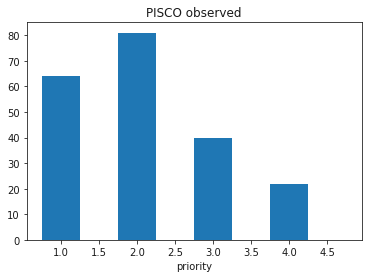

In [26]:
plt.hist(total[(total['pisco_all']==True)]['priority2'],bins=np.arange(0.75,5.75,1),width=0.5)
plt.xlabel('priority')
plt.title('PISCO observed')

In [434]:
# total[(total['pisco_all']==False)&(total['panstar']==False)]

Text(0.5,1,'PISCO not observed/PANSTARR observed')

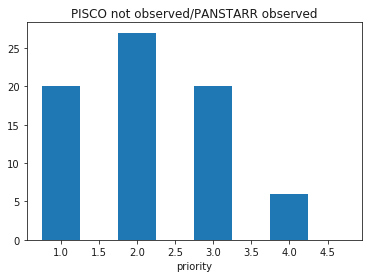

In [27]:
plt.hist(total[(total['pisco_all']==False)&(total['panstar']==True)]['priority2'],bins=np.arange(0.75,5.75,1),width=0.5)
plt.xlabel('priority')
plt.title('PISCO not observed/PANSTARR observed')

Text(0.5,1,'PISCO not observed/PANSTARR not observed')

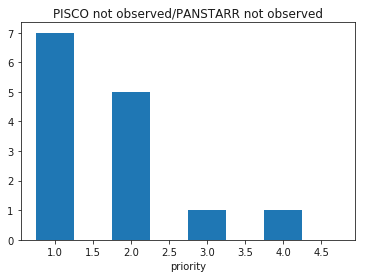

In [28]:
plt.hist(total[(total['pisco_all']==False)&(total['panstar']==False)]['priority2'],bins=np.arange(0.75,5.75,1),width=0.5)
plt.xlabel('priority')
plt.title('PISCO not observed/PANSTARR not observed')

In [29]:
total.iloc[0]['pisco']

False

In [30]:
total.iloc[np.argmin(sep)]['pisco']

False

In [31]:
total['pisco'].iloc[293]=True

In [32]:
total['pisco'].iloc[293]

True

In [33]:
find_ra_dec('Field087')

(229.72749, -32.03861, -1.0)

In [34]:
base_field[base_field.name=='Field087']

NameError: name 'base_field' is not defined

In [35]:
-43.57623068466675
-34.934569299688185

for i in total[(total['ra_01']<336.99975202151825+1)&(total['ra_01']>336.99975202151825-1)]['chips']:
    print i

CHIPS2228-3220
CHIPS2230-3942
CHIPS2227-4333


[294, 288, 140]


Text(0.5,1,'Mike observation removed')

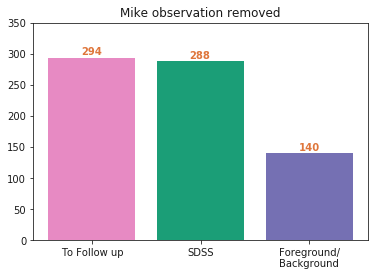

In [37]:
cut=df.copy()
x = cut['followup'].value_counts()
head=['To Follow up','SDSS','Foreground/\nBackground']
value=[x.values[0],x.values[1],x.values[2]+x.values[3]]
print value

plt.bar(range(len(head)), value, align='center', color=['#e78ac3','#1b9e77','#7570b3'])
plt.xticks(range(len(head)), head, size='medium')
for i in range(len(head)):
    plt.text(i-0.1,value[i]+5,value[i],color='#DF763B',family='sans-serif',weight='bold')
plt.ylim(0,350)
plt.title('Mike observation removed')
#plt.savefig('/Users/taweewat/Documents/chandra/figure/barchart.pdf', bbox_inches='tight')

In [44]:
total.to_csv('/Users/taweewat/Documents/xray_project/ned-result/total_cut.csv')

## Making plot for all the objects

In [2]:
total=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/final_all_new.csv',index_col=0)
total=total.dropna(subset=['emir','eradio','exray'])

In [3]:
obj={'Abell 1835':(210.258631,2.878468),'Phoenix':(356.18307,-42.720204),'NGC 1275':(49.950416,41.51166),'PKS1353-341':(209.02244416666667,-34.35301638888889)}
all_match={}
for i, item in enumerate(obj.keys()):
    print item
    matched=total.loc[(((total.loc[:,'ra']-obj[item][0])**2+(total.loc[:,'dec']-obj[item][1])**2)**0.5).idxmin(),:]
    print (matched['ra']-obj[item][0])*3600
    print (matched['dec']-obj[item][1])*3600
    all_match[item]=matched
    
all_match_df=pd.DataFrame.from_dict(all_match,orient='index')
all_match_df.reset_index(level=0, inplace=True)

phoenix=all_match_df[all_match_df['index']=='Phoenix']
cut2=total[(total['mir']+total['emir']>phoenix['mir'].values[0]-np.log10(3*5)) &\
           (total['radio']+total['eradio']>phoenix['radio'].values[0]-np.log10(3.*3)) &\
           (total['xray']+total['exray']>phoenix['xray'].values[0]-np.log10(3))]

PKS1353-341
-5.81100000006
26.339
Abell 1835
0.464399999953
7.0272
NGC 1275
-10.4976
10.044
Phoenix
2.44799999996
-6.75359999998


In [8]:
##3D plot

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection='3d')

for index,i in enumerate(np.concatenate([np.arange(1,9,0.5),np.sort(np.arange(1.5,9,0.5))[::-1]])):
    ax.scatter(total['mir'],total['radio'],total['xray'],c='#7570b3',linewidth=0.2,edgecolor='black')
    ax.scatter(cut2['mir'],cut2['radio'],cut2['xray'],c='#e78ac3',linewidth=0.2,edgecolor='black')
#     ax.scatter(phoenix['mir'],phoenix['radio'],phoenix['xray'],marker='o',c='r',s=200,linewidth=1,edgecolor='black')
    ax.set_xlabel('MIR/NIR')
    ax.set_ylabel('Radio/NIR')
    ax.set_zlabel('Xray/NIR')
    ax.view_init(30, 10*i)
    plt.savefig('allplot_%02i.jpg'%index,dpi=72)
    
plt.close()
# plt.show()

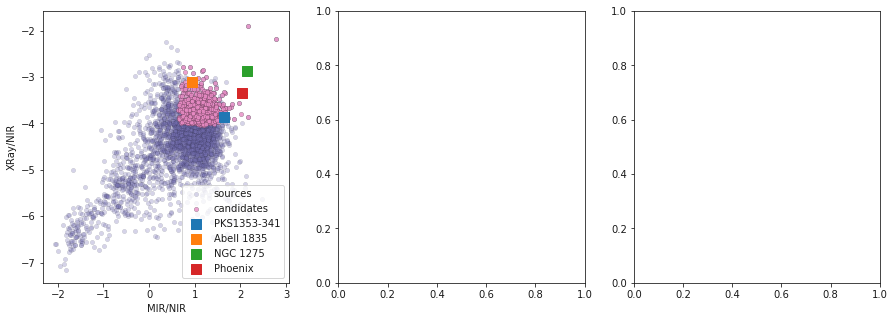

In [6]:
mir=total.dropna()['mir'].values
xray=total.dropna()['xray'].values
radio=total.dropna()['radio'].values

fig, ax = plt.subplots(1, 3, figsize=(15,5))

point=ax[0].scatter(mir,xray,alpha=0.3, c='#7570b3', label='sources',s=20.,linewidth=0.2,edgecolor='black')
ax[0].scatter(cut2['mir'],cut2['xray'],alpha=0.8,c='#e78ac3',label='candidates',s=20,linewidth=0.2,edgecolor='black')
for i, item in enumerate(all_match.keys()):
    ax[0].scatter(all_match[item]['mir'],all_match[item]['xray'],alpha=1.0,label=item,s=100.0,marker='s')
ax[0].set_xlabel('MIR/NIR')
ax[0].set_ylabel('XRay/NIR')
ax[0].legend(loc='lower right')

In [866]:
total=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/total_cut_des_panstar.csv',index_col=0)
df_sd=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/total_sdss.csv',index_col=0) #with SDSS name

new_pisco=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/new_chips_name.csv',names=['chips'])
total['pisco_all']=total['pisco_all'] | total['chips'].apply(lambda row: True if row in new_pisco['chips'].values else False)

df_pisco=total[total['pisco_all']==True]
df_panstar=total[(total['pisco_all']==False) & (total['panstar']==True)]
df_des=total[total['des']==True]
print df_sd.shape, df_pisco.shape, df_panstar.shape, df_des.shape

print total[(total['panstar']==False)&(total['pisco_all']==False)&(total['des']==False)].shape

(374, 69) (228, 77) (66, 77) (96, 77)
(0, 77)


In [947]:
total=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/total_776_new_pan.csv',index_col=0)
total[(total['dec_01']<-29)&(total['panstar']==True)].sort_values(by='dec_01').head()

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,eradio,redshift,sep,type,SDSS,reject,followup,chips,pisco,panstar
255,5.092390,110.077745,80.65916,-29.48708,80.660686,-29.487566,0.0580,0.0594,-0.0064,14.590,...,0.087774,0.769279,5.0,G,no,reject,outSD/outside,CHIPS0522-2929,False,True
311,4.982558,-65.037905,6.12708,-29.48236,6.125639,-29.481776,0.0415,0.0403,0.0022,13.392,...,0.046632,0.406450,5.1,QSO,no,not_reject,follow,CHIPS0024-2928,True,True
333,22.071424,-135.728277,20.52625,-29.33055,20.521341,-29.334940,0.0595,0.0597,-0.0098,14.482,...,0.077641,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS0122-2919,False,True
250,25.215985,-81.674950,18.03917,-29.31847,18.031221,-29.317456,0.0645,0.0611,-0.0140,14.600,...,0.111999,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS0112-2919,True,True
563,13.497420,-140.126420,212.86667,-29.23181,212.863915,-29.234687,0.0433,0.0428,-0.0054,13.523,...,0.039238,0.340532,13.5,G,no,not_reject,follow,CHIPS1411-2913,True,True


In [944]:
total.loc[(total['dec_01']<-29.5),'panstar']=False

In [87]:
#new edited 4/23/19
infile = open('/Users/taweewat/Documents/xray_project/code_github/allremove_chips_new.txt', 'r')
exception = [i.strip() for i in infile.readlines()]

total=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/total_776_new_pan.csv',index_col=0)
total=total[np.where(total['chips'].isin(exception),False,True)]
df_sd=total[total['SDSS']=='yes']

df_pisco=total[total['pisco']==True]
df_panstar=total[(total['panstar']==True)&(total['pisco']==False)&(total['SDSS']=='no')&(total['followup']=='follow')]

print df_sd.shape, df_pisco.shape, df_panstar.shape

print total[(total['panstar']==False)&(total['pisco']==False)&(total['SDSS']==False)].shape

(386, 75) (215, 75) (66, 75)
(0, 75)


In [88]:
total[total['chips']=='CHIPS1940-2104']

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,reject,followup,chips,pisco,panstar,name,pisco_new,f_lim_panstar,f_lim_sdss,f_lim_pisco
242,14.88428,60.175933,295.23499,-21.0825,295.238834,-21.080444,0.1095,0.1146,-0.0206,15.132,...,not_reject,follow,CHIPS1940-2104,False,True,0.0,False,21.351077,-99.0,-99.0


In [78]:
# df_none=total[(total['panstar']==False)&(total['pisco_all']==False)&(total['des']==False)]

In [59]:
# print np.sum((total['des']==True))#&(total['pisco_all']==True))
# print np.sum((total['des']==True)&(total['panstar']==False)&(total['pisco_all']==False))
# print np.sum((total['pisco_all']==False)&(total['des']==True))
# total[(total['des']==True)&(total['panstar']==True)&(total['pisco_all']==False)]

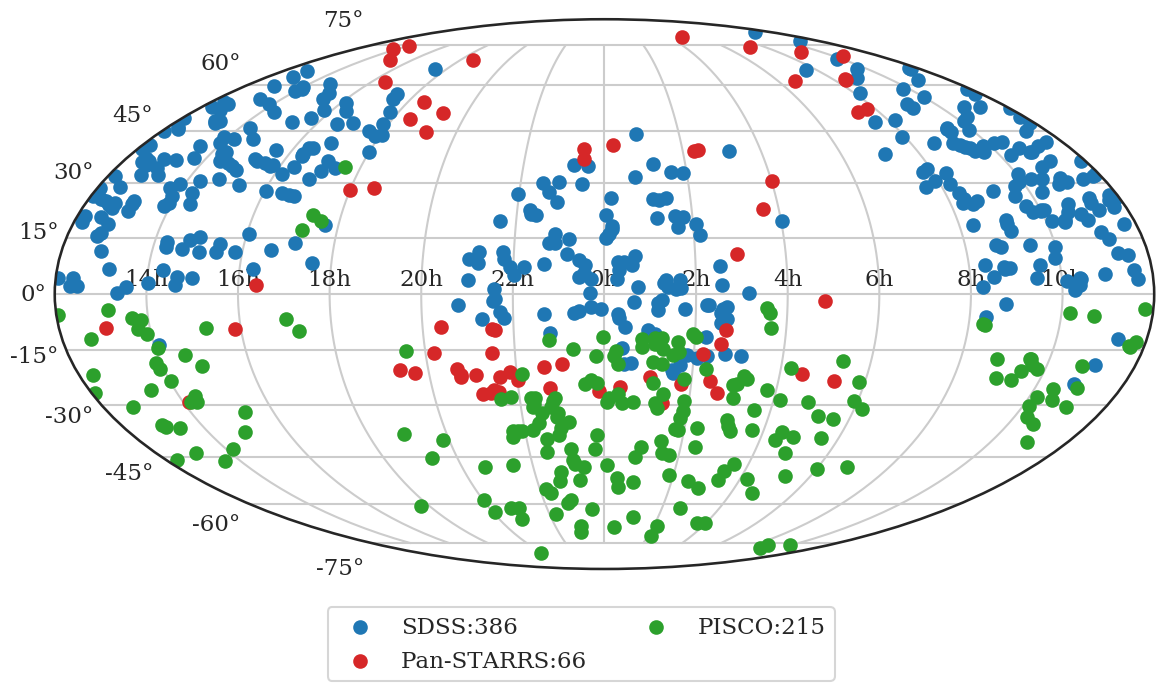

In [91]:
import astropy.coordinates as coord
sns.set(context='talk',style='ticks',font='serif',rc={"xtick.direction":"in","ytick.direction":"in"})

ra = coord.Angle(df_sd['ra'].values*u.degree); ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(df_sd['dec'].values*u.degree)

ra_pan = coord.Angle(df_panstar['ra'].values*u.degree)
ra_pan = ra_pan.wrap_at(180*u.degree)
dec_pan = coord.Angle(df_panstar['dec'].values*u.degree)

ra_pis = coord.Angle(df_pisco['ra'].values*u.degree)
ra_pis = ra_pis.wrap_at(180*u.degree)
dec_pis = coord.Angle(df_pisco['dec'].values*u.degree)

# ra_des = coord.Angle(df_des['ra'].values*u.degree)
# ra_des = ra_des.wrap_at(180*u.degree)
# dec_des = coord.Angle(df_des['dec'].values*u.degree)

# ra_none = coord.Angle(df_none['ra'].values*u.degree)
# ra_none = ra_none.wrap_at(180*u.degree)
# dec_none = coord.Angle(df_none['dec'].values*u.degree)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian,c='tab:blue',alpha=1,label='SDSS:%i'%len(ra.radian))
ax.scatter(ra_pan.radian, dec_pan.radian,c='tab:red',alpha=1,label='Pan-STARRS:%i'%len(ra_pan.radian))
ax.scatter(ra_pis.radian, dec_pis.radian,c='tab:green',alpha=1,label='PISCO:%i'%len(ra_pis.radian))
# ax.scatter(ra_none.radian, dec_none.radian,c='grey',alpha=1,marker='x',label='None')
# ax.scatter(ra_des.radian, dec_des.radian,alpha=1,label='DES',s=100,edgecolor='orange', facecolor='none',lw=1.5)

# x0=SkyCoord(ra=total[total['chips']=='CHIPS0133+3039'].ra.values*u.degree, dec=total[total['chips']=='CHIPS0133+3039'].dec.values*u.degree)
# ax.scatter(x0.ra.radian, x0.dec.radian,marker='^',c='tab:orange',alpha=1,label='PISCO')

ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend(bbox_to_anchor=(0.5,0.15),loc="center",bbox_transform=fig.transFigure, ncol=2)
fig.tight_layout()
# plt.savefig('/Users/taweewat/Documents/red_sequence/pisco_color_plots/sample_sky.pdf', dpi=120)

sns.reset_orig()

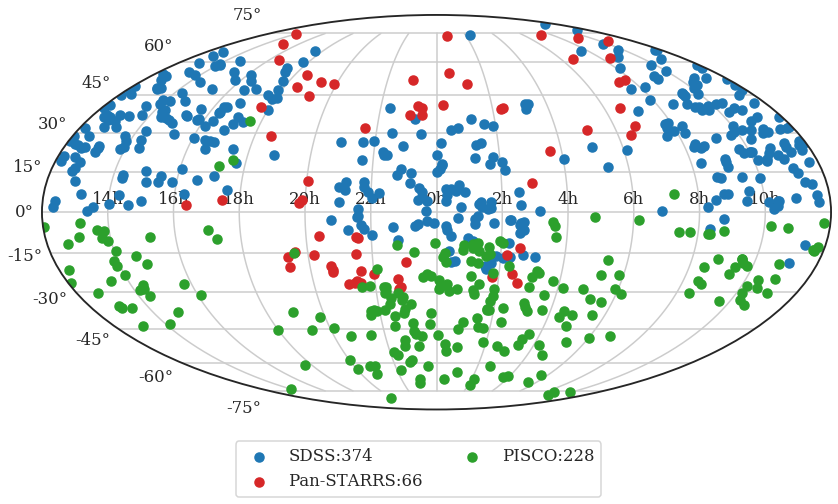

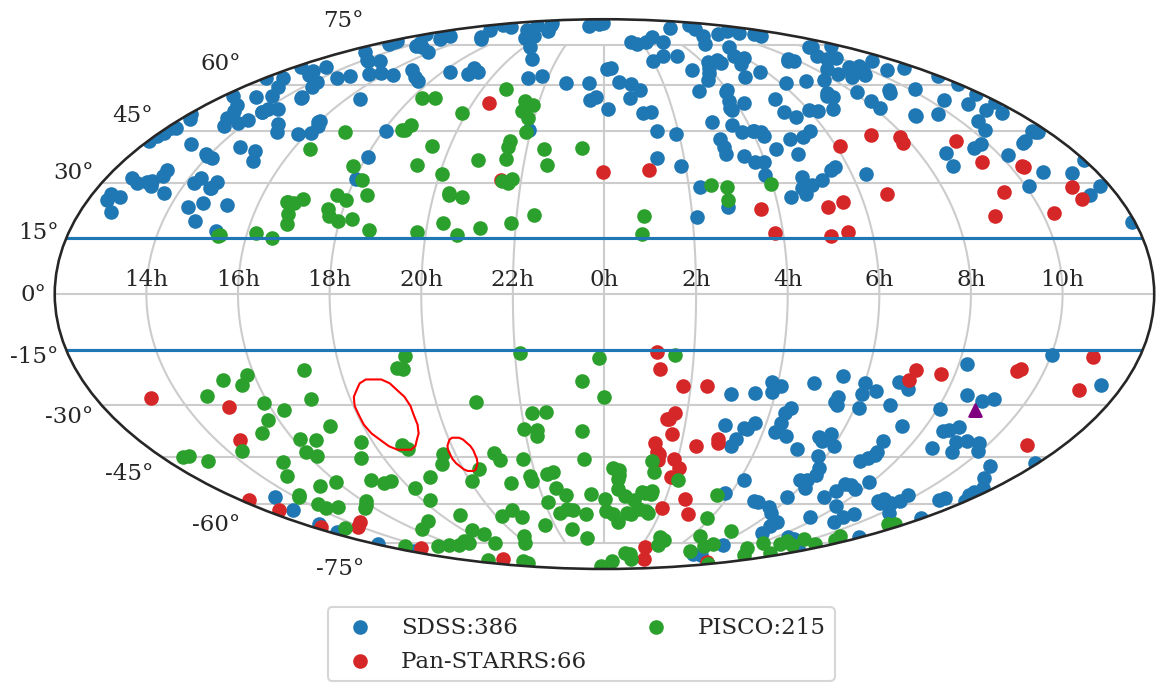

In [98]:
import astropy.coordinates as coord
sns.set(context='talk',style='ticks',font='serif',rc={"xtick.direction":"in","ytick.direction":"in"})

LMC = SkyCoord("05 23 34.6 -69 45 22", unit=(u.hourangle, u.deg))
SMC = SkyCoord("00 52 38.0 -72 48 01", unit=(u.hourangle, u.deg))

ra = coord.Angle(df_sd['ra'].values*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(df_sd['dec'].values*u.degree)
gal_long=SkyCoord(ra=df_sd['ra_01'].values*u.degree, dec=df_sd['dec_01'].values*u.degree).galactic.l.wrap_at(180*u.degree)
gal_lat=SkyCoord(ra=df_sd['ra_01'].values*u.degree, dec=df_sd['dec_01'].values*u.degree).galactic.b


ra_pan = coord.Angle(df_panstar['ra'].values*u.degree)
ra_pan = ra_pan.wrap_at(180*u.degree)
dec_pan = coord.Angle(df_panstar['dec'].values*u.degree)
gal_long_pan=SkyCoord(ra=df_panstar['ra_01'].values*u.degree, dec=df_panstar['dec_01'].values*u.degree).galactic.l.wrap_at(180*u.degree)
gal_lat_pan=SkyCoord(ra=df_panstar['ra_01'].values*u.degree, dec=df_panstar['dec_01'].values*u.degree).galactic.b


ra_pis = coord.Angle(df_pisco['ra'].values*u.degree)
ra_pis = ra_pis.wrap_at(180*u.degree)
dec_pis = coord.Angle(df_pisco['dec'].values*u.degree)
gal_long_pis=SkyCoord(ra=df_pisco['ra'].values*u.degree, dec=df_pisco['dec'].values*u.degree).galactic.l.wrap_at(180*u.degree)
gal_lat_pis=SkyCoord(ra=df_pisco['ra'].values*u.degree, dec=df_pisco['dec'].values*u.degree).galactic.b

# gal_long_des=SkyCoord(ra=df_des['ra'].values*u.degree, dec=df_des['dec'].values*u.degree).galactic.l.wrap_at(180*u.degree)
# gal_lat_des=SkyCoord(ra=df_des['ra'].values*u.degree, dec=df_des['dec'].values*u.degree).galactic.b

# gal_long_none=SkyCoord(ra=df_none['ra'].values*u.degree, dec=df_none['dec'].values*u.degree).galactic.l.wrap_at(180*u.degree)
# gal_lat_none=SkyCoord(ra=df_none['ra'].values*u.degree, dec=df_none['dec'].values*u.degree).galactic.b

dds=df_pisco[(gal_lat_pis.to(u.degree).value<15.)&(gal_lat_pis.to(u.degree).value>-15.)]
gal_long_ex=SkyCoord(ra=dds['ra'].values*u.degree, dec=dds['dec'].values*u.degree).galactic.l.wrap_at(180*u.degree)
gal_lat_ex=SkyCoord(ra=dds['ra'].values*u.degree, dec=dds['dec'].values*u.degree).galactic.b


fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(gal_long.radian, gal_lat.radian,c='tab:blue',alpha=1,label='SDSS:%i'%len(gal_long.radian))
ax.scatter(gal_long_pan.radian, gal_lat_pan.radian,c='tab:red',alpha=1,label='Pan-STARRS:%i'%len(gal_long_pan.radian))
ax.scatter(gal_long_pis.radian, gal_lat_pis.radian,c='tab:green',alpha=1,label='PISCO:%i'%len(gal_long_pis.radian))
# ax.scatter(gal_long_none.radian, gal_lat_none.radian,c='grey',marker='x',alpha=1,label='PISCO')
# ax.scatter(gal_long_des.radian, gal_lat_des.radian,alpha=1,label='DES',s=100,edgecolor='orange', facecolor='none',lw=1.5)
# ax.scatter(gal_long_ex.radian, gal_lat_ex.radian,c='tab:orange',marker='^',alpha=1,label='PISCO')


# field='Field179'
x0=SkyCoord(ra=23.46209*u.degree, dec= 30.65903*u.degree)
ax.scatter(x0.galactic.l.wrap_at(180*u.degree).radian, x0.galactic.b.radian,c='purple',marker='^',alpha=1)

clmc = Circle((LMC.galactic.l.wrap_at(180*u.degree).radian, LMC.galactic.b.radian), (600*u.arcmin).to(u.radian).value, edgecolor='red', facecolor='none')
ax.add_patch(clmc)
csmc = Circle((SMC.galactic.l.wrap_at(180*u.degree).radian, SMC.galactic.b.radian), (300*u.arcmin).to(u.radian).value, edgecolor='red', facecolor='none')
ax.add_patch(csmc)

c5 = SkyCoord(ra=df_pisco['ra_01'].values*u.degree, dec=df_pisco['dec_01'].values*u.degree)
sep = c5.separation(LMC)
ax.scatter(gal_long_pis.radian[sep.to(u.arcminute).value<=300.], gal_lat_pis.radian[sep.to(u.arcminute).value<=300.],\
           c='black',alpha=1)

# ax.scatter(gal_long_pis.radian[df_pisco['name']=='Field039'], gal_lat_pis.radian[df_pisco['name']=='Field039'],\
#            c='black',alpha=1,label='PISCO')


ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend(bbox_to_anchor=(0.5,0.15),loc="center",bbox_transform=fig.transFigure, ncol=2)
fig.tight_layout()
# plt.savefig('pisco_color_plots/all_object_sky.pdf', dpi=120)
plt.axhline(15./180*np.pi)
plt.axhline(-15./180*np.pi)

sns.reset_orig()

In [102]:
df_sd[(gal_lat.degree>-17)&(gal_lat.degree<0)]

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,reject,followup,chips,pisco,panstar,name,pisco_new,f_lim_panstar,f_lim_sdss,f_lim_pisco
372,11.36267,165.914281,47.60125,39.18583,47.602241,39.182769,0.0418,0.0391,-0.0046,12.848,...,not_reject,followed,CHIPS0310+3911,False,True,0.0,False,-99.0,21.998123,-99.0


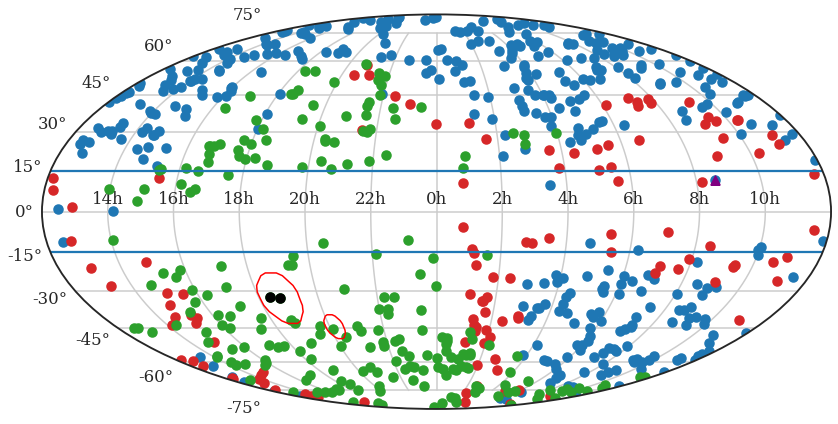

/Users/taweewat/anaconda2/lib/python2.7/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/Users/taweewat/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


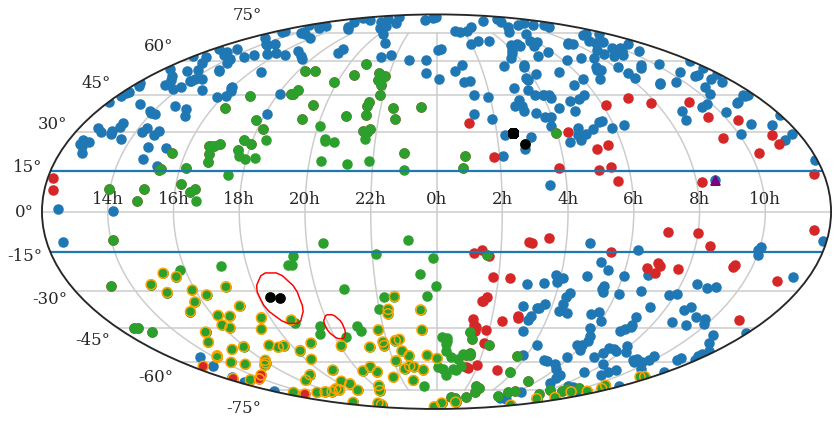

In [294]:
# df_richness=pd.DataFrame(columns=['name','zmax','nmax','signal','lum_factor','density_factor'])
# df_richness.append(pd.Series({'name':'CHIPS1011', 'zmax':0.5, 'nmax':20, 'signal':0.9, 'lum_factor':0.9, 'density_factor':0.3}),ignore_index=True)

In [481]:
df_pisco[sep.to(u.arcminute).value<=300.]['name']

699    CHIPS0525-6938
700    CHIPS0535-6602
Name: name, dtype: object

In [449]:
c5 = SkyCoord(ra=df_pisco['ra_01'].values*u.degree, dec=df_pisco['dec_01'].values*u.degree)
sep = c5.separation(LMC)
[sep.to(u.arcminute).value<=600.]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [351]:
x0.to_string('hmsdms')

u'05h09m30.7992s -67d31m16.5s'

In [337]:
find_ra_dec('Field179')

(77.37833, -67.52125, -1.0)

In [335]:
SkyCoord(ra=find_ra_dec('Field179')[0]*u.degree, dec=find_ra_dec('Field179')[1]*u.degree)

<SkyCoord (ICRS): (ra, dec) in deg
    (77.37833, -67.52125)>

In [333]:
find_ra_dec('Field179')

(77.37833, -67.52125, -1.0)

In [833]:
dds=df_pisco[(gal_lat_pis.to(u.degree).value<15.)&(gal_lat_pis.to(u.degree).value>-15.)]
for i in dds['chips']:
    print '%s'%i

CHIPS0609-0247
CHIPS0745-0714
CHIPS0827-2026
CHIPS0837-2649
CHIPS0715+0642
CHIPS0724-0715
CHIPS0828-2553
CHIPS0936-3342
CHIPS1757-4535
CHIPS1356-7406


In [834]:
for i in df_sd[(gal_lat.to(u.degree).value<15.)&(gal_lat.to(u.degree).value>-15.)]['chips']:
    print '%s'%i

CHIPS0217+7349
CHIPS2220+3948
CHIPS2053+2613
CHIPS0501+2423
CHIPS0605+2315
CHIPS1849+2127
CHIPS0521+1638
CHIPS0651+0025
CHIPS0313+4120
CHIPS0319+4130


In [835]:
for i in df_panstar[(gal_lat_pan.to(u.degree).value<15.)&(gal_lat_pan.to(u.degree).value>-15.)]['chips']:
    print '%s'%i

CHIPS2302+5149
CHIPS2135+3149
CHIPS2001+1144
CHIPS0811-1010
CHIPS1833-2104
CHIPS0043+7344
CHIPS0113+4948
CHIPS0501+3048
CHIPS0530+1332
CHIPS0621+1747
CHIPS0626+2911
CHIPS0633+3939
CHIPS0643+3236
CHIPS1733-1304
CHIPS1913-2049
CHIPS1946+0202
CHIPS1952+4958
CHIPS1953+0434
CHIPS2109+3532


In [126]:
df_pisco_rm=df_pisco[~df_pisco.index.isin(dds.index)]

## Inside Galactic Plane
1. CHIPS0609-0247
2. CHIPS0745-0714
3. CHIPS0827-2026
4. Field071 (CHIPS0837-2649)
5. Field194 (CHIPS0715+0642)
6. CHIPS0724-0715
7. CHIPS0824-3020
8. Field201 (CHIPS0828-2553)
9. CHIPS0936-3342
10. Field103
11. Field226 (CHIPS1356-7406)

## no_panstar/nopisco
- CHIPS1303-3613 no A
- CHIPS1423-3125 no C
- CHIPS1855-3806 no A
- CHIPS1950-4000 no B 
- CHIPS1410-4247 no D
- CHIPS1917-4530 no B
- CHIPS2007-4434 no B
- CHIPS2038-4803 yes A
- CHIPS2003-6300 no A
- CHIPS2052-6523 no A
- CHIPS1304-4353 no B
- CHIPS1742-6055 no B
- CHIPS1949-7945 no A
- CHIPS2045-6133 yes A

In [359]:
for i, row in df_miss.iterrows():
    print '-', row['chips'], row['ra_01'], ',', row['dec_01'], row['priority']

- CHIPS1303-3613 195.82793 , -36.23111 A
- CHIPS1423-3125 215.88333 , -31.42375 C
- CHIPS1855-3806 283.88165 , -38.10972 A
- CHIPS1950-4000 297.54001 , -40.00361 B
- CHIPS1410-4247 212.58458 , -42.79042 D
- CHIPS1917-4530 289.42126 , -45.50361 B
- CHIPS2007-4434 301.98419 , -44.58055 B
- CHIPS2038-4803 309.59039 , -48.055 A
- CHIPS2003-6300 300.94086 , -63.00597 A
- CHIPS2052-6523 313.02832 , -65.39125 A
- CHIPS1304-4353 196.08833 , -43.88556 B
- CHIPS1742-6055 265.50626 , -60.92056 B
- CHIPS1949-7945 297.43585 , -79.75542 A
- CHIPS2045-6133 311.43085 , -61.55181 A


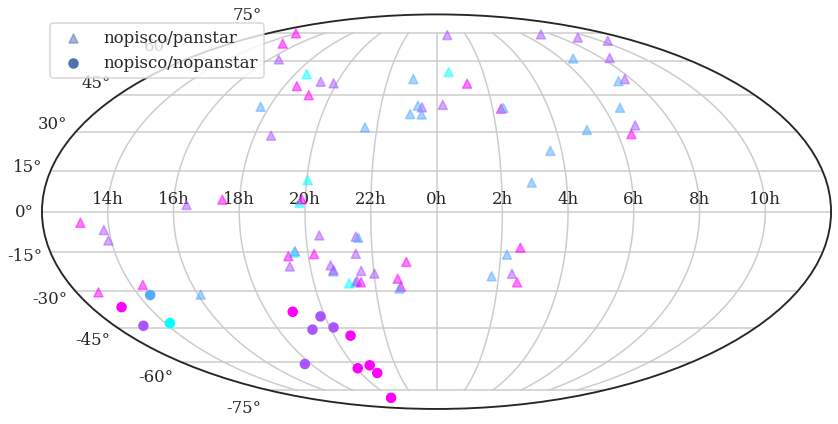

In [296]:
df_miss=total[(total['pisco_all']==False)&(total['panstar']==False)]
df_misspan=total[(total['pisco_all']==False)&(total['panstar']==True)]

sns.set(context='talk',style='ticks',font='serif',rc={"xtick.direction":"in","ytick.direction":"in"})

ra = coord.Angle(df_misspan['ra'].values*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(df_misspan['dec'].values*u.degree)

ra_pan = coord.Angle(df_miss['ra_01'].values*u.degree)
ra_pan = ra_pan.wrap_at(180*u.degree)
dec_pan = coord.Angle(df_miss['dec_01'].values*u.degree)

# ra_pis = coord.Angle(df_pisco['ra'].values*u.degree)
# ra_pis = ra_pis.wrap_at(180*u.degree)
# dec_pis = coord.Angle(df_pisco['dec'].values*u.degree)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian,marker='^', c=df_misspan['priority2'], alpha=0.5,label='nopisco/panstar', cmap='cool_r')
axi=ax.scatter(ra_pan.radian, dec_pan.radian, c=df_miss['priority2'], alpha=1, label='nopisco/nopanstar', cmap='cool_r')
# ax.scatter(ra_pis.radian, dec_pis.radian,c='tab:green',alpha=1,label='PISCO')
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend(loc='best')
fig.tight_layout()
# plt.colorbar(axi)
# plt.savefig('pisco_color_plots/all_object_sky.pdf', dpi=120)

sns.reset_orig()

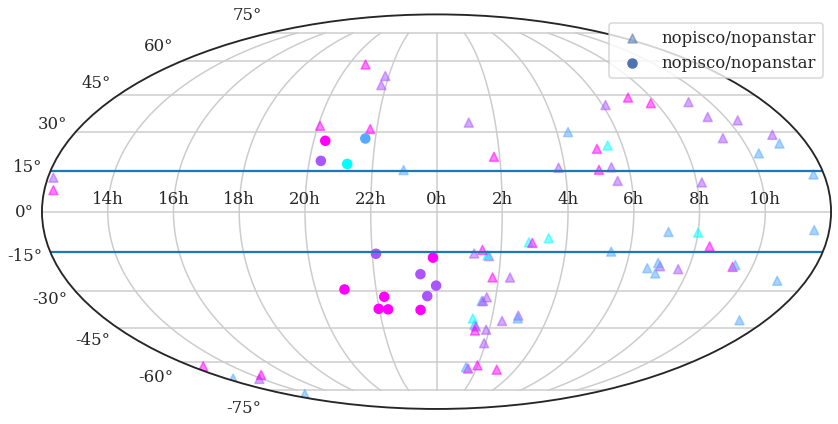

In [309]:
df_miss=total[(total['pisco_all']==False)&(total['panstar']==False)]
df_misspan=total[(total['pisco_all']==False)&(total['panstar']==True)]

sns.set(context='talk',style='ticks',font='serif',rc={"xtick.direction":"in","ytick.direction":"in"})

ra = coord.Angle(df_misspan['ra'].values*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(df_misspan['dec'].values*u.degree)
gal_long=SkyCoord(ra=df_misspan['ra_01'].values*u.degree, dec=df_misspan['dec_01'].values*u.degree).galactic.l.wrap_at(180*u.degree)
gal_lat=SkyCoord(ra=df_misspan['ra_01'].values*u.degree, dec=df_misspan['dec_01'].values*u.degree).galactic.b

ra_pan = coord.Angle(df_miss['ra_01'].values*u.degree)
ra_pan = ra_pan.wrap_at(180*u.degree)
dec_pan = coord.Angle(df_miss['dec_01'].values*u.degree)
gal_long_pan=SkyCoord(ra=df_miss['ra_01'].values*u.degree, dec=df_miss['dec_01'].values*u.degree).galactic.l.wrap_at(180*u.degree)
gal_lat_pan=SkyCoord(ra=df_miss['ra_01'].values*u.degree, dec=df_miss['dec_01'].values*u.degree).galactic.b

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection="mollweide")
axi=ax.scatter(gal_long.radian, gal_lat.radian,marker='^',c=df_misspan['priority2'], alpha=0.5, label='nopisco/nopanstar', cmap='cool_r')
axi=ax.scatter(gal_long_pan.radian, gal_lat_pan.radian, c=df_miss['priority2'], alpha=1, label='nopisco/nopanstar', cmap='cool_r')
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend(loc='best')
fig.tight_layout()
plt.axhline(15./180*np.pi)
plt.axhline(-15./180*np.pi)

sns.reset_orig()

In [563]:
df_pisco[df_pisco['name']=='CHIPS0957-7554']

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,reject,followup,chips,priority,panstar,pisco,outside_pisco,priority2,pisco_all,name
705,13653,6.629263,-118.986899,149.32458,-75.90889,149.317963,-75.909782,0.0434,0.044,0.0049,...,not_reject,follow,CHIPS0957-7554,A,False,False,True,1,True,CHIPS0957-7554


In [325]:
filename='all_richness_gnorm_zf2.5_bc03_noebv_auto_bin1.0_root15.csv'
filename='all_richness_gnorm_zf2.5_bc03_noebv_auto_bin1.0_root15_cbgr3.csv'
df_richness=pd.read_csv('/Users/taweewat/Documents/red_sequence/'+filename)

In [326]:
# df_richness_cut[df_richness_cut['name']=='Field179']

In [113]:
galactic=["CHIPS0609-0247","CHIPS0745-0714","CHIPS0827-2026","Field071","Field194","CHIPS0724-0715",\
          "CHIPS0824-3020","Field201","CHIPS0936-3342","Field103","Field226","SDSS0217+7349","SDSS2220+3948",\
          "SDSS2053+2613","SDSS0501+2423","SDSS0605+2315","SDSS1849+2127","SDSS0521+1638","SDSS0651+0025",\
          "SDSS0313+4120","SDSS0319+4130","CHIPS0031+5459","CHIPS2302+5149","CHIPS2135+3149","CHIPS2001+1144",\
          "CHIPS0609-0247","CHIPS0745-0714","CHIPS0827-2026","CHIPS0837-2649","CHIPS0043+7344","CHIPS0113+4948",\
          "CHIPS0501+3048","CHIPS0626+2911","CHIPS0633+3939","CHIPS0643+3236","CHIPS0715+0642","CHIPS0724-0715",\
          "CHIPS0828-2553","CHIPS1922-1632","CHIPS1949+0317","CHIPS1952+4958","CHIPS1953+0434"] #pisco+sdss+panstar
LMC=["CHIPS0525-6938","CHIPS0535-6602"]
bad_name #not in the new version of Field list (new matching catalog)

allremove=galactic+LMC+bad_name

In [114]:
with open('allremove_chips.txt', 'w') as f:
    for item in allremove:
        f.write("%s\n" % item)

In [329]:
infile = open('allremove_chips.txt', 'r')
allremove=[i.strip() for i in infile.readlines()]

In [330]:
infile = open('allremove_chips.txt', 'r')
allremove=[i.strip() for i in infile.readlines()]
cut=np.array([i in allremove for i in df_richness['name']])
df_richness_cut=df_richness[~cut].copy()

In [174]:
df_richness[['Nmax','Nbkg_mean','Nbkg_median','zmax','amp','zmax_fit','gremove','lum_factor','density_factor']]=np.nan

In [179]:
df_richness_cut=df_richness.copy()

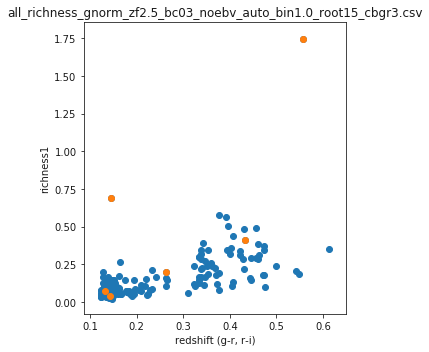

In [180]:
fig=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
xaxis='zmax_fit'
y=df_richness_cut['amp']#*(df_richness['lum_factor']*df_richness['density_factor'])
df_richness_cut['richness']=y
# y_near=df_richness_cut[df_richness_cut['zmax']<0.175]
# print 'normalization:', np.max(y_near['richness'])
norm=1;#norm=np.max(y_near['richness'])
plt.scatter(df_richness_cut[xaxis],y/norm);

cut=df_richness_cut[df_richness_cut['name'].isin(['Field292','CHIPS1011-0505','Field094','CHIPS0137-1248','CHIPS0005-2758','Field159'])]
plt.scatter(cut[xaxis],cut['richness']/norm);
# for i, txt in enumerate(cut.name.values):
#     plt.annotate(txt, (cut.iloc[i][xaxis],cut.iloc[i]['richness']/norm))

plt.xlabel('redshift (g-r, r-i)')
plt.ylabel('richness1')
plt.title(filename)

plt.tight_layout()

In [157]:
df_richness_cut[df_richness_cut['name']=='Field234']

,name,Nmax,Nbkg_mean,Nbkg_median,zmax,amp,zmax_fit,gremove,lum_factor,density_factor,richness
87,Field234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
df_pisco[df_pisco['name']=='Field234']

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,followup,chips,priority,panstar,pisco,outside_pisco,priority2,pisco_all,name,des
569,11969,0.24907,58.061573,264.12292,34.68375,264.122991,34.683787,0.0461,0.0454,-0.0054,...,follow,CHIPS1736+3441,A,True,True,False,1,True,Field234,False


In [560]:
df_richness_cut[df_richness_cut['zmax_fit']<0.106]

,name,Nmax,Nbkg_mean,Nbkg_median,zmax,amp,zmax_fit,gremove,lum_factor,density_factor,richness


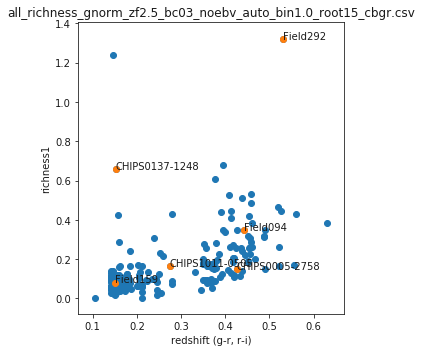

In [185]:
field='CHIPS1011-0505'
fname = "/Users/taweewat/Documents/pisco_code/slr_output/total_psf_%s.csv"%field
df0 = pd.read_csv(fname)

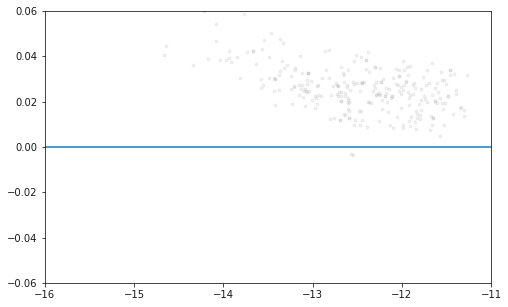

In [194]:
plt.plot(df0['MAG_AUTO_i'],df0['SPREAD_MODEL_i'],'.',c='grey',alpha=0.1)
plt.ylim(-0.06,0.06)
plt.xlim(-16,-11)
plt.axhline(0)

In [912]:
total[total['chips']=='CHIPS1933-1511']

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,eradio,redshift,sep,type,SDSS,reject,followup,chips,pisco,panstar
221,3.568379,66.717187,293.49084,-15.19958,293.491783,-15.199188,0.0576,0.0573,-0.0099,14.211,...,0.104897,-1.0,-1.0,NaN,no,not_reject,follow,CHIPS1933-1511,True,True


In [917]:
print total[total['pisco']==True].shape
print total[(total['panstar']==True)&(total['pisco']==False)&(total['SDSS']=='no')&(total['followup']=='follow')].shape
print total[(total['panstar']==True)&(total['pisco']==True)&(total['SDSS']=='no')&(total['followup']=='follow')].shape
print total[(total['panstar']==True)&(total['SDSS']=='no')&(total['followup']=='follow')].shape

(228, 70)
(83, 70)
(119, 70)
(202, 70)


In [914]:
fs=total[(total['panstar']==True)&(total['SDSS']=='no')&(total['followup']=='follow')]
fs[fs['chips']=='CHIPS1933-1511']

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,eradio,redshift,sep,type,SDSS,reject,followup,chips,pisco,panstar
221,3.568379,66.717187,293.49084,-15.19958,293.491783,-15.199188,0.0576,0.0573,-0.0099,14.211,...,0.104897,-1.0,-1.0,NaN,no,not_reject,follow,CHIPS1933-1511,True,True


In [918]:
total[total['chips']=='CHIPS1721+2111']

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,eradio,redshift,sep,type,SDSS,reject,followup,chips,pisco,panstar
114,17.454417,-113.340545,260.39334,21.18569,260.388566,21.183769,0.0459,0.0467,-0.0067,13.975,...,0.074289,-1.0,-1.0,NaN,no,not_reject,follow,CHIPS1721+2111,True,True
